In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [10]:
from pathlib import Path
import pickle
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

In [4]:
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.analysis.state_space import StateSpaceAnalysisSpec

In [5]:
sns.set_theme(style="whitegrid", context="talk", font_scale=2)

In [46]:
plot_dataset = "timit"
plot_base_model = "w2v2_8"
plot_model_classes = ["rnn_8", "rnn_3-weightdecay0.01", "rnn_8-weightdecay0.01"]
plot_equivalences = ["random", "phoneme_10frames", "syllable_10frames", "word_broad_10frames"]

In [8]:
equiv_dataset_path = f"outputs/equivalence_datasets/{plot_dataset}/{plot_base_model}/{plot_equivalences[-1]}/equivalence.pkl"
timit_corpus_path = f"outputs/preprocessed_data/{plot_dataset}"
state_space_spec_path = f"outputs/state_space_specs/{plot_dataset}/{plot_base_model}/state_space_specs.pkl"

In [12]:
state_space_specs = torch.load(state_space_spec_path)
word_trajectory_spec = state_space_specs["word"]
phoneme_trajectory_spec = state_space_specs["phoneme"]
syllable_trajectory_spec = state_space_specs["syllable"]

## Preliminary length statistics

In [13]:
word_frame_durations = pd.Series([end - start for frame_spans in word_trajectory_spec.target_frame_spans for start, end in frame_spans])
phoneme_frame_durations = pd.Series([end - start for frame_spans in phoneme_trajectory_spec.target_frame_spans for start, end in frame_spans])
syllable_frame_durations = pd.Series([end - start for frame_spans in syllable_trajectory_spec.target_frame_spans for start, end in frame_spans])

In [14]:
lengths_df = pd.concat([word_frame_durations, phoneme_frame_durations, syllable_frame_durations],
                       keys=["word", "phoneme", "syllable"], names=["unit"]).rename("length").reset_index()
lengths_df["duration"] = lengths_df["length"] / 20

In [15]:
lengths_df

unit  level_1  length  duration
0           word        0       8      0.40
1           word        1       7      0.35
2           word        2      10      0.50
3           word        3      10      0.50
4           word        4      13      0.65
...          ...      ...     ...       ...
330619  syllable    78972      15      0.75
330620  syllable    78973      20      1.00
330621  syllable    78974      26      1.30
330622  syllable    78975       8      0.40
330623  syllable    78976      21      1.05

[330624 rows x 4 columns]

phoneme 0.2
syllable 0.45
word 0.7


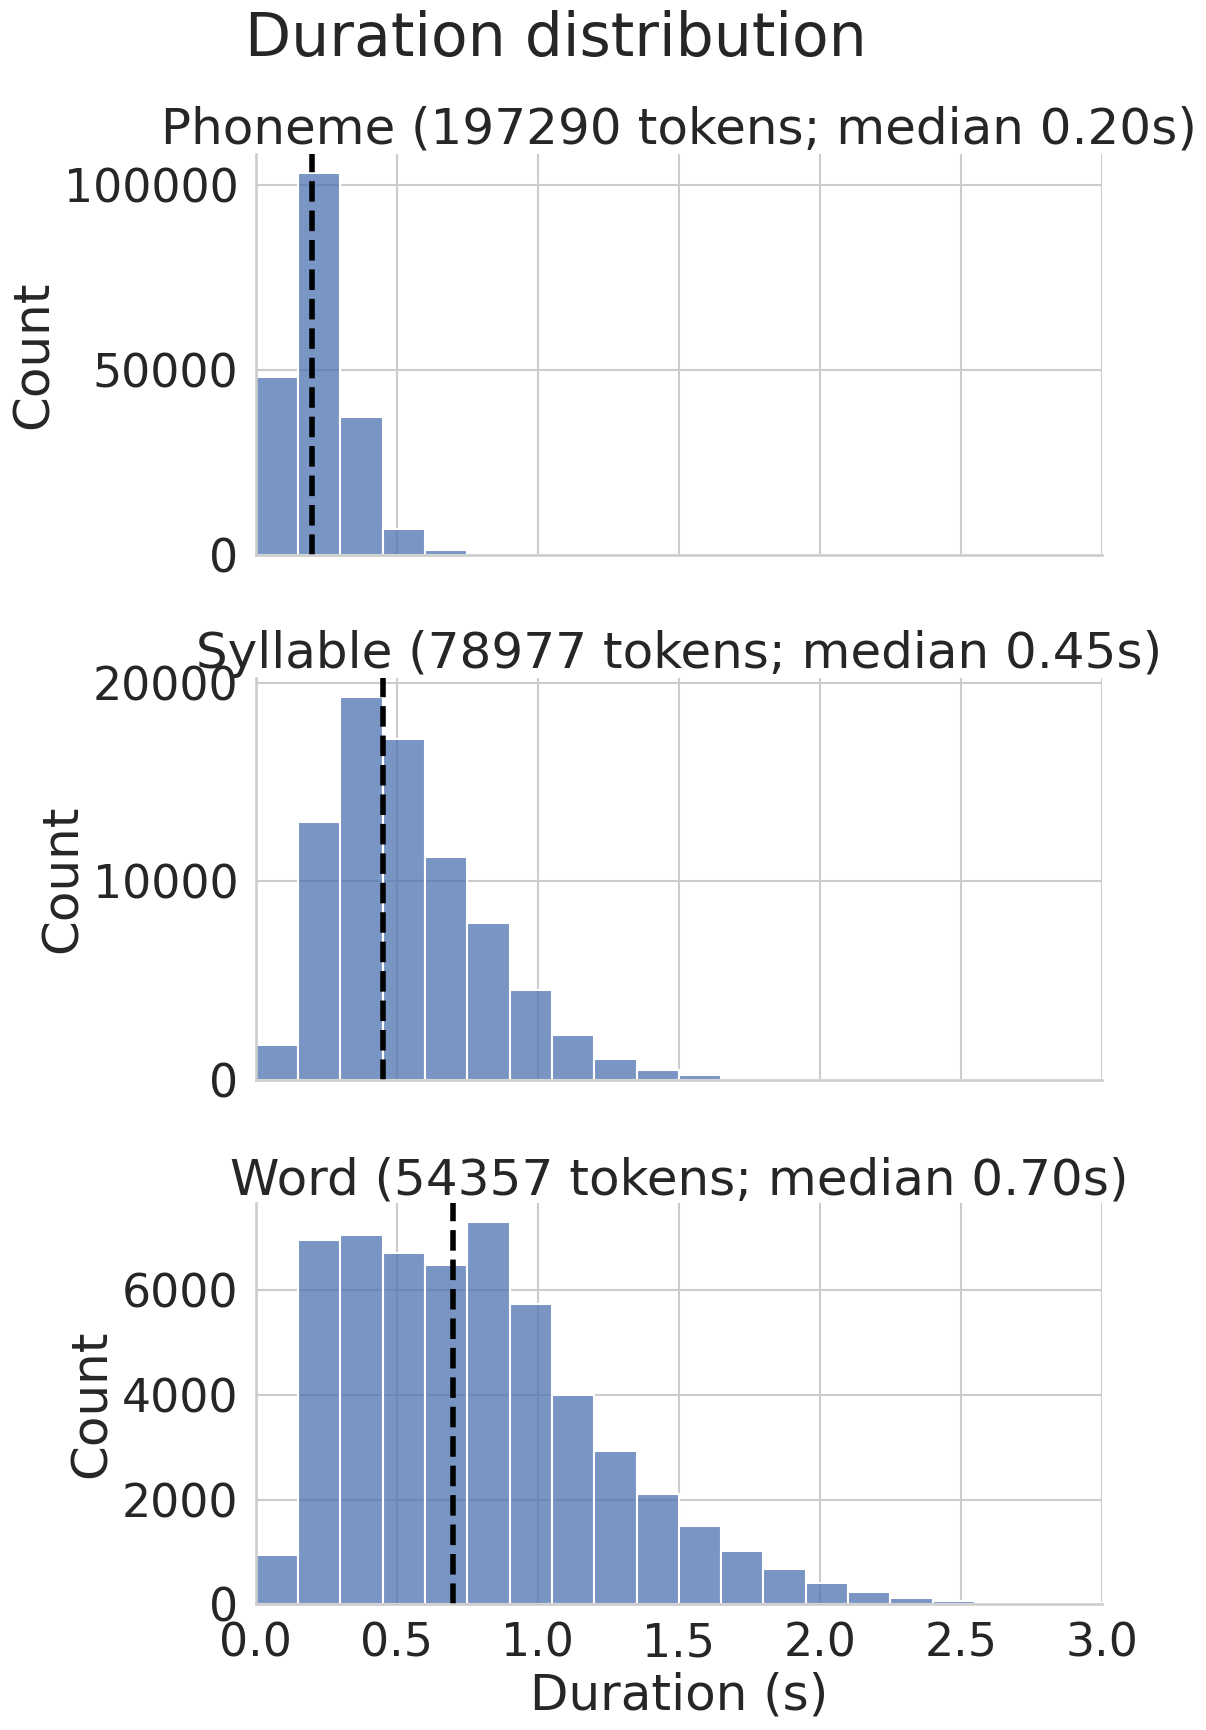

In [16]:
row_order = ["phoneme", "syllable", "word"]
g = sns.displot(
    lengths_df.reset_index(), x="duration", row="unit", row_order=row_order,
    binwidth=3 / 20, height=6, aspect=2, facet_kws=dict(sharey=False),
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Duration distribution")

for ax, unit in zip(g.axes.flat, row_order):
    median_length = lengths_df[lengths_df["unit"] == unit]["duration"].median()
    ax.set_title(f"{unit.capitalize()} ({len(lengths_df[lengths_df['unit'] == unit])} tokens; median {median_length:.2f}s)")
    ax.set_xlabel("Duration (s)")
    ax.set_ylabel("Count")
    ax.set_xlim((0, 3))

    print(unit, median_length)
    ax.axvline(median_length, color="black", linestyle="--", linewidth=4)

In [17]:
phoneme_in_word_df = word_trajectory_spec.cuts.xs("phoneme", level="level")
phoneme_in_word_df["idx_in_level"] = phoneme_in_word_df.groupby(["label", "instance_idx"]).cumcount()
phoneme_in_word_df["rev_idx_in_level"] = phoneme_in_word_df.groupby(["label", "instance_idx"]).cumcount(ascending=False)
phoneme_in_word_df

/tmp/ipykernel_711648/54656410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phoneme_in_word_df["idx_in_level"] = phoneme_in_word_df.groupby(["label", "instance_idx"]).cumcount()
/tmp/ipykernel_711648/54656410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phoneme_in_word_df["rev_idx_in_level"] = phoneme_in_word_df.groupby(["label", "instance_idx"]).cumcount(ascending=False)


description  onset_frame_idx  offset_frame_idx  item_idx  \
label instance_idx                                                            
'em   0                     AH           129121            129123       852   
      0                      M           129123            129125       852   
      1                     AH           204156            204159      1352   
      1                      M           204159            204162      1352   
      2                     AH           204247            204251      1352   
...                        ...              ...               ...       ...   
zoos  5                     UW           514588            514603      3338   
      5                      S           514603            514617      3338   
      6                      Z           596767            596772      3877   
      6                     UW           596772            596786      3877   
      6                      Z           596786            596791      3877   

                    idx_in_level  rev_idx_in_level  
label instance_idx                                  
'em   0                        0                 1  
      0                        1                 0  
      1                        0                 1  
      1                        1                 0  
      2                        0                 1  
...                          ...               ...  
zoos  5                        1                 1  
      5                        2                 0  
      6                        0                 2  
      6                        1                 1  
      6                        2                 0  

[197290 rows x 6 columns]

In [18]:
phoneme_in_syllable_df = syllable_trajectory_spec.cuts.xs("phoneme", level="level")
phoneme_in_syllable_df["idx_in_level"] = phoneme_in_syllable_df.groupby(["label", "instance_idx"]).cumcount()
phoneme_in_syllable_df["rev_idx_in_level"] = phoneme_in_syllable_df.groupby(["label", "instance_idx"]).cumcount(ascending=False)
phoneme_in_syllable_df

description  onset_frame_idx  offset_frame_idx  \
label          instance_idx                                                  
(AA,)          0                     AA              839               845   
               1                     AA             9383              9397   
               2                     AA            13234             13242   
               3                     AA            13271             13279   
               4                     AA            13509             13514   
...                                 ...              ...               ...   
(ZH, UW, L)    7                      L           914483            914488   
(ZH, UW, W, L) 0                     ZH             8236              8238   
               0                     UW             8238              8241   
               0                      W             8241              8244   
               0                      L             8244              8248   

                             item_idx  idx_in_level  rev_idx_in_level  
label          instance_idx                                            
(AA,)          0                    6             0                 0  
               1                   62             0                 0  
               2                   85             0                 0  
               3                   85             0                 0  
               4                   86             0                 0  
...                               ...           ...               ...  
(ZH, UW, L)    7                 5974             2                 0  
(ZH, UW, W, L) 0                   55             0                 3  
               0                   55             1                 2  
               0                   55             2                 1  
               0                   55             3                 0  

[197290 rows x 6 columns]

In [19]:
phoneme_in_syllable_df[phoneme_in_syllable_df.idx_in_level == 6]

description  onset_frame_idx  \
label                    instance_idx                                
(AE, M, B, Y, L, N, S)   0                      S           176881   
(B, Y, IH, L, N, T, S)   0                      S           512415   
(D, IH, S, T, N, T, S)   0                      S           767041   
                         1                      S           829449   
(F, AH, NG, K, SH, N, L) 0                      L           352562   
...                                           ...              ...   
(T, R, EH, M, B, L, D)   0                      D           462171   
                         1                      D           783804   
(T, S, K, AE, F, L, D)   0                      D           736474   
(V, EH, JH, T, B, L, Z)  0                      Z           158312   
                         1                      Z           641055   

                                       offset_frame_idx  item_idx  \
label                    instance_idx                               
(AE, M, B, Y, L, N, S)   0                       176885      1176   
(B, Y, IH, L, N, T, S)   0                       512420      3326   
(D, IH, S, T, N, T, S)   0                       767049      5007   
                         1                       829454      5417   
(F, AH, NG, K, SH, N, L) 0                       352567      2332   
...                                                 ...       ...   
(T, R, EH, M, B, L, D)   0                       462176      3022   
                         1                       783806      5122   
(T, S, K, AE, F, L, D)   0                       736479      4812   
(V, EH, JH, T, B, L, Z)  0                       158317      1048   
                         1                       641059      4168   

                                       idx_in_level  rev_idx_in_level  
label                    instance_idx                                  
(AE, M, B, Y, L, N, S)   0                        6                 0  
(B, Y, IH, L, N, T, S)   0                        6                 0  
(D, IH, S, T, N, T, S)   0                        6                 0  
                         1                        6                 0  
(F, AH, NG, K, SH, N, L) 0                        6                 0  
...                                             ...               ...  
(T, R, EH, M, B, L, D)   0                        6                 0  
                         1                        6                 0  
(T, S, K, AE, F, L, D)   0                        6                 0  
(V, EH, JH, T, B, L, Z)  0                        6                 0  
                         1                        6                 0  

[70 rows x 6 columns]

In [20]:
# Phoneme stats

# mean onset of each phoneme relative to syllable start
phoneme_in_syllable_df["relative_onset"] = phoneme_in_syllable_df.onset_frame_idx - phoneme_in_syllable_df.groupby(["label", "instance_idx"]).onset_frame_idx.min()
phoneme_in_syllable_mean_onsets = phoneme_in_syllable_df.groupby("idx_in_level").relative_onset.mean() / 20
phoneme_in_word_df["relative_onset"] = phoneme_in_word_df.onset_frame_idx - phoneme_in_word_df.groupby(["label", "instance_idx"]).onset_frame_idx.min()
phoneme_in_word_mean_onsets = phoneme_in_word_df.groupby("idx_in_level").relative_onset.mean() / 20

# mean onset of each phoneme indexed from end, relative to end
phoneme_in_syllable_df["reverse_relative_onset"] = phoneme_in_syllable_df.onset_frame_idx - phoneme_in_syllable_df.groupby(["label", "instance_idx"]).offset_frame_idx.max()
phoneme_in_syllable_reverse_mean_onsets = -phoneme_in_syllable_df.groupby("rev_idx_in_level").reverse_relative_onset.mean() / 20
phoneme_in_word_df["reverse_relative_onset"] = phoneme_in_word_df.onset_frame_idx - phoneme_in_word_df.groupby(["label", "instance_idx"]).offset_frame_idx.max()
phoneme_in_word_reverse_mean_onsets = -phoneme_in_word_df.groupby("rev_idx_in_level").reverse_relative_onset.mean() / 20
phoneme_in_word_reverse_mean_onsets

/tmp/ipykernel_711648/3890120054.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phoneme_in_word_df["relative_onset"] = phoneme_in_word_df.onset_frame_idx - phoneme_in_word_df.groupby(["label", "instance_idx"]).onset_frame_idx.min()
/tmp/ipykernel_711648/3890120054.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phoneme_in_word_df["reverse_relative_onset"] = phoneme_in_word_df.onset_frame_idx - phoneme_in_word_df.groupby(["label", "instance_idx"]).offset_frame_idx.max()


rev_idx_in_level
0     0.200325
1     0.417045
2     0.654208
3     0.830979
4     1.014654
5     1.187947
6     1.347631
7     1.507806
8     1.664979
9     1.815901
10    1.998939
11    2.227692
12    2.429592
13    2.721875
14    2.800000
15    3.250000
Name: reverse_relative_onset, dtype: float64

In [21]:
equiv_dataset = torch.load(equiv_dataset_path)

# Coherence analyses

In [22]:
def truncate_contrasts(distance_df, min_contrast_instances=50) -> pd.DataFrame:
    # We want to make comparisons between contrasts only when we have enough data
    # between individual units in the contrast to have a meaningful mean.
    # e.g. if a "within" contrast at frame 5 only has 2 instances, it's not so informative to compare this mean to the "between" contrast at frame 5.

    # Find the maximum frame at which, for all contrasts, we have at least `min_contrast_instances` instances
    # underlying each contrast value.
    max_contrast_frame = distance_df.groupby(["model", "equivalence", "frame"]) \
        .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \
        .groupby(["model", "equivalence"]).idxmax().str[-1].min()
    
    return distance_df[distance_df.frame < max_contrast_frame]

In [51]:
def load_grouped_distances(glob, plot_models, plot_equivalences, min_contrast_instances=50):
    syll_onset_paths = list(Path("outputs/notebooks").glob(glob))

    syll_onset_keys, syll_onset_dfs = [], []
    for path in syll_onset_paths:
        syll_onset_dfs.append(pd.read_csv(path))

        dataset, base_model, model_class, equivalence = path.parts[-6:-2]
        if model_class.startswith("random"):
            model_class = model_class[len("random"):]
        syll_onset_keys.append((dataset, base_model, model_class, equivalence))

    syll_onset_distance_df = pd.concat(syll_onset_dfs, names=["dataset", "base_model", "model", "equivalence"], keys=syll_onset_keys)
    syll_onset_distance_df = syll_onset_distance_df.loc[
        syll_onset_distance_df.index.get_level_values("equivalence").isin(plot_equivalences) &
        syll_onset_distance_df.index.get_level_values("model").isin(plot_models)]
    syll_onset_distance_df = truncate_contrasts(syll_onset_distance_df, min_contrast_instances=min_contrast_instances)

    return syll_onset_distance_df

In [24]:
def plot_coherence(coherence_df, unit, alignment="onset",
                   plot_phonemes=None, sharex=True, legend=False, plot_kwargs=None, **kwargs):
    coherence_df = coherence_df.reset_index()
    coherence_df["equivalence"] = coherence_df.equivalence.str.capitalize()

    default_kwargs = dict(col_wrap=2)
    kwargs = {**default_kwargs, **kwargs}
    g = sns.FacetGrid(data=coherence_df, col="equivalence", col_order=[e.capitalize() for e in plot_equivalences],
                      sharex=sharex, sharey=True, height=8, aspect=2, **kwargs)
    g.map(sns.lineplot, "time", "distance", "type", **(plot_kwargs or {}))

    if legend:
        g.add_legend()
    g.set_titles(template="{col_name}")

    for ax in g.axes.flat:
        ax.grid(False)
        ax.set_ylim((-0.2, 1.2))
        ax.axhline(0, color="gray", linestyle="--", alpha=0.8)
        ax.axhline(1, color="gray", linestyle="--", alpha=0.8)
        ax.set_ylabel("Cosine distance")

        if alignment == "onset":
            ax.set_xlim((-.065, ax.get_xlim()[1]))
            ax.set_xlabel(f"Time since {unit} onset (s)")
            ax.axvline(0, color="gray", linestyle="--", linewidth=4)
            ymin, ymax = ax.get_ylim()
            ax.text(0, (ymax - ymin) / 3, f"{unit.capitalize()} onset", color="gray",
                    rotation=90, ha="right", va="center",
                    fontsize="large", fontweight="bold")
        elif alignment == "offset":
            ax.set_xlabel(f"Time until {unit} offset (s)")
            ax.axvline(0, color="gray", linestyle="--", linewidth=4)
            ymin, ymax = ax.get_ylim()
            ax.text(-0.05, (ymax - ymin) / 3, f"{unit.capitalize()} offset", color="gray",
                    rotation=90, ha="left", va="center",
                    fontsize="large", fontweight="bold")

        if plot_phonemes is not None:
            xmin, xmax = ax.get_xlim()
            for phoneme_onset in plot_phonemes:
                if phoneme_onset < xmax:
                    ax.axvline(phoneme_onset, color="salmon", linestyle="--", alpha=0.5)

    if alignment == "offset":
        if sharex:
            # will apply to all
            g.axes.flat[0].invert_xaxis()
        else:
            for ax in g.axes.flat:
                ax.invert_xaxis()

    return g

## Phoneme-level coherence

In [48]:
phoneme_distance_by_position_df = load_grouped_distances(
    f"{plot_dataset}/{plot_base_model}/**/phoneme_coherence_by_position/distances.csv",
    plot_model_classes, plot_equivalences, min_contrast_instances=10)
phoneme_distance_by_position_df["time"] = phoneme_distance_by_position_df["frame"] / 20

[('timit', 'w2v2_8', 'rnn_8', 'random'), ('timit', 'w2v2_8', 'rnn_3-weightdecay0.01', 'phoneme_10frames'), ('timit', 'w2v2_8', 'rnn_3-weightdecay0.01', 'next_phoneme_10frames'), ('timit', 'w2v2_8', 'ff_32', 'random'), ('timit', 'w2v2_8', 'ff_8', 'random'), ('timit', 'w2v2_8', 'rnn_8-weightdecay0.01', 'syllable_10frames'), ('timit', 'w2v2_8', 'rnn_8-weightdecay0.01', 'biphone_pred_10frames'), ('timit', 'w2v2_8', 'rnn_8-weightdecay0.01', 'word_10frames'), ('timit', 'w2v2_8', 'rnn_8-weightdecay0.01', 'word_broad_10frames'), ('timit', 'w2v2_8', 'rnn_8-weightdecay0.01', 'biphone_recon_10frames'), ('timit', 'w2v2_8', 'rnn_32', 'random')]


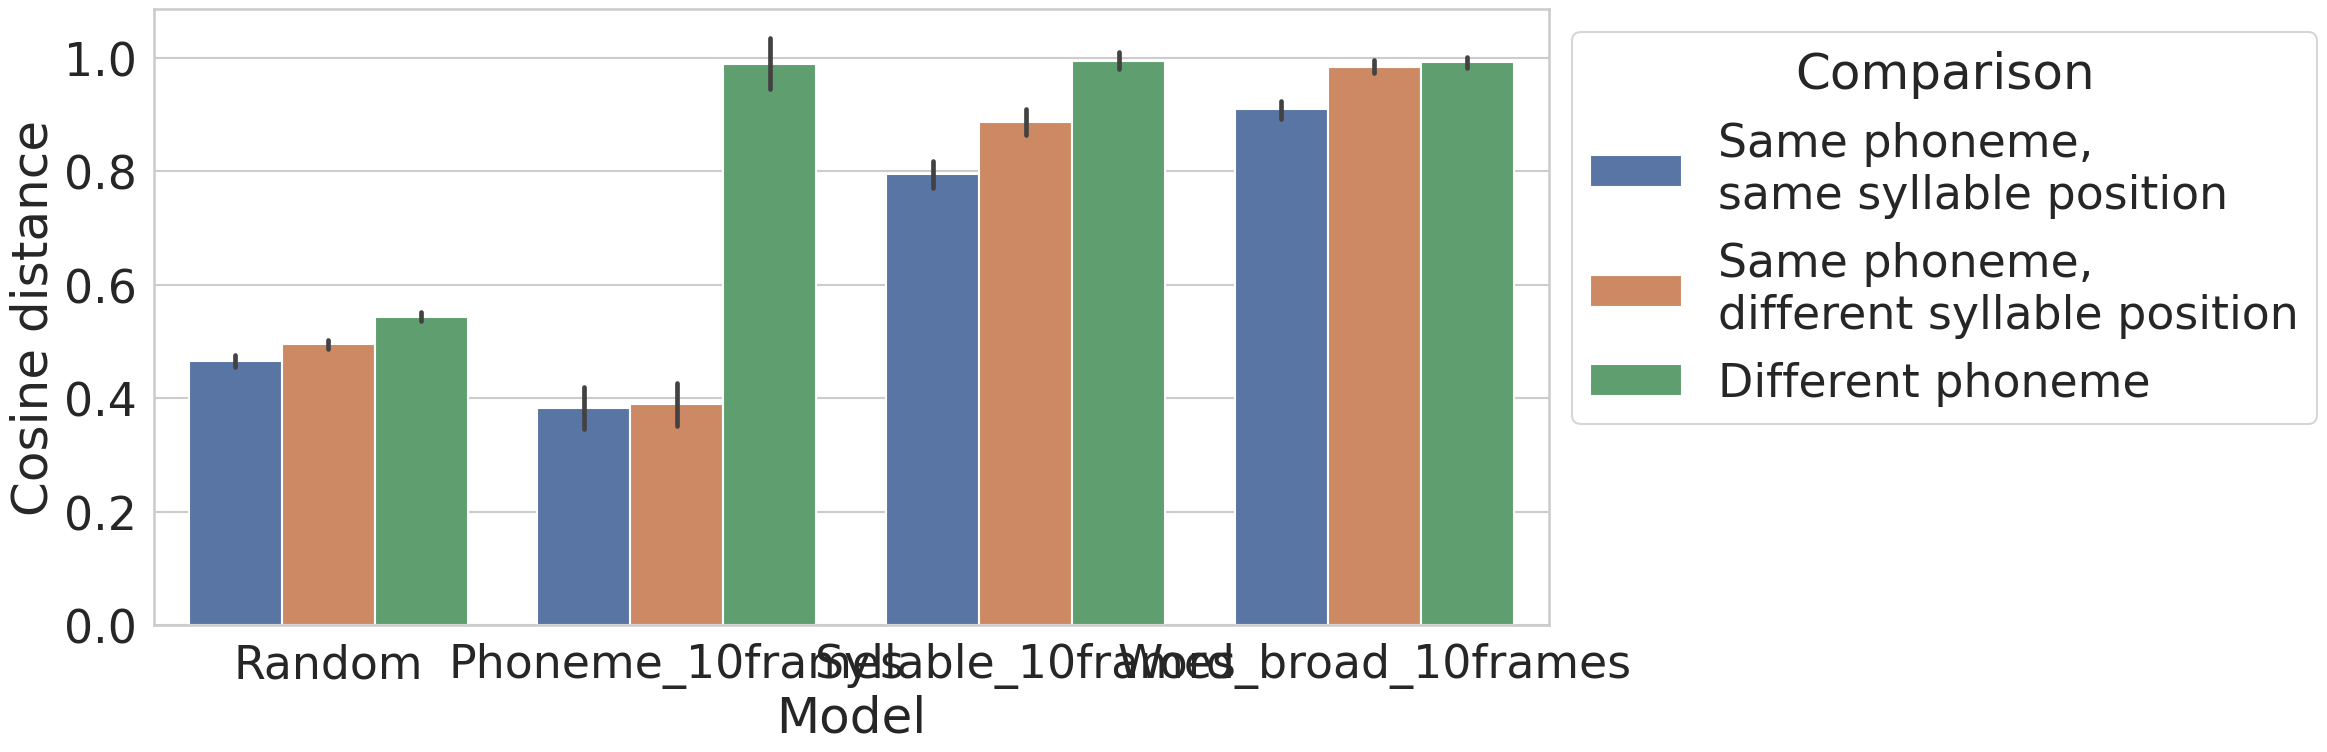

In [50]:
f, ax = plt.subplots(figsize=(18, 8))
phoneme_plot_data = phoneme_distance_by_position_df.reset_index()
phoneme_plot_data["equivalence"] = phoneme_plot_data["equivalence"].str.capitalize()
phoneme_plot_data["type"] = phoneme_plot_data["type"].map(
    {"within": "Same phoneme,\nsame syllable position",
     "different_position": "Same phoneme,\ndifferent syllable position",
     "between": "Different phoneme"}
)
sns.barplot(data=phoneme_plot_data,
            x="equivalence", y="distance", hue="type", ax=ax)

ax.set_ylabel("Cosine distance")
ax.set_xlabel("Model")
ax.legend(title="Comparison", loc="upper left", bbox_to_anchor=(1, 1))

### By phoneme category

In [52]:
phoneme_distance_by_cv_df = load_grouped_distances(
    "**/phoneme_coherence/grouped_distances.csv", plot_model_classes, plot_equivalences)
phoneme_distance_by_cv_df["time"] = phoneme_distance_by_cv_df["frame"] / 20

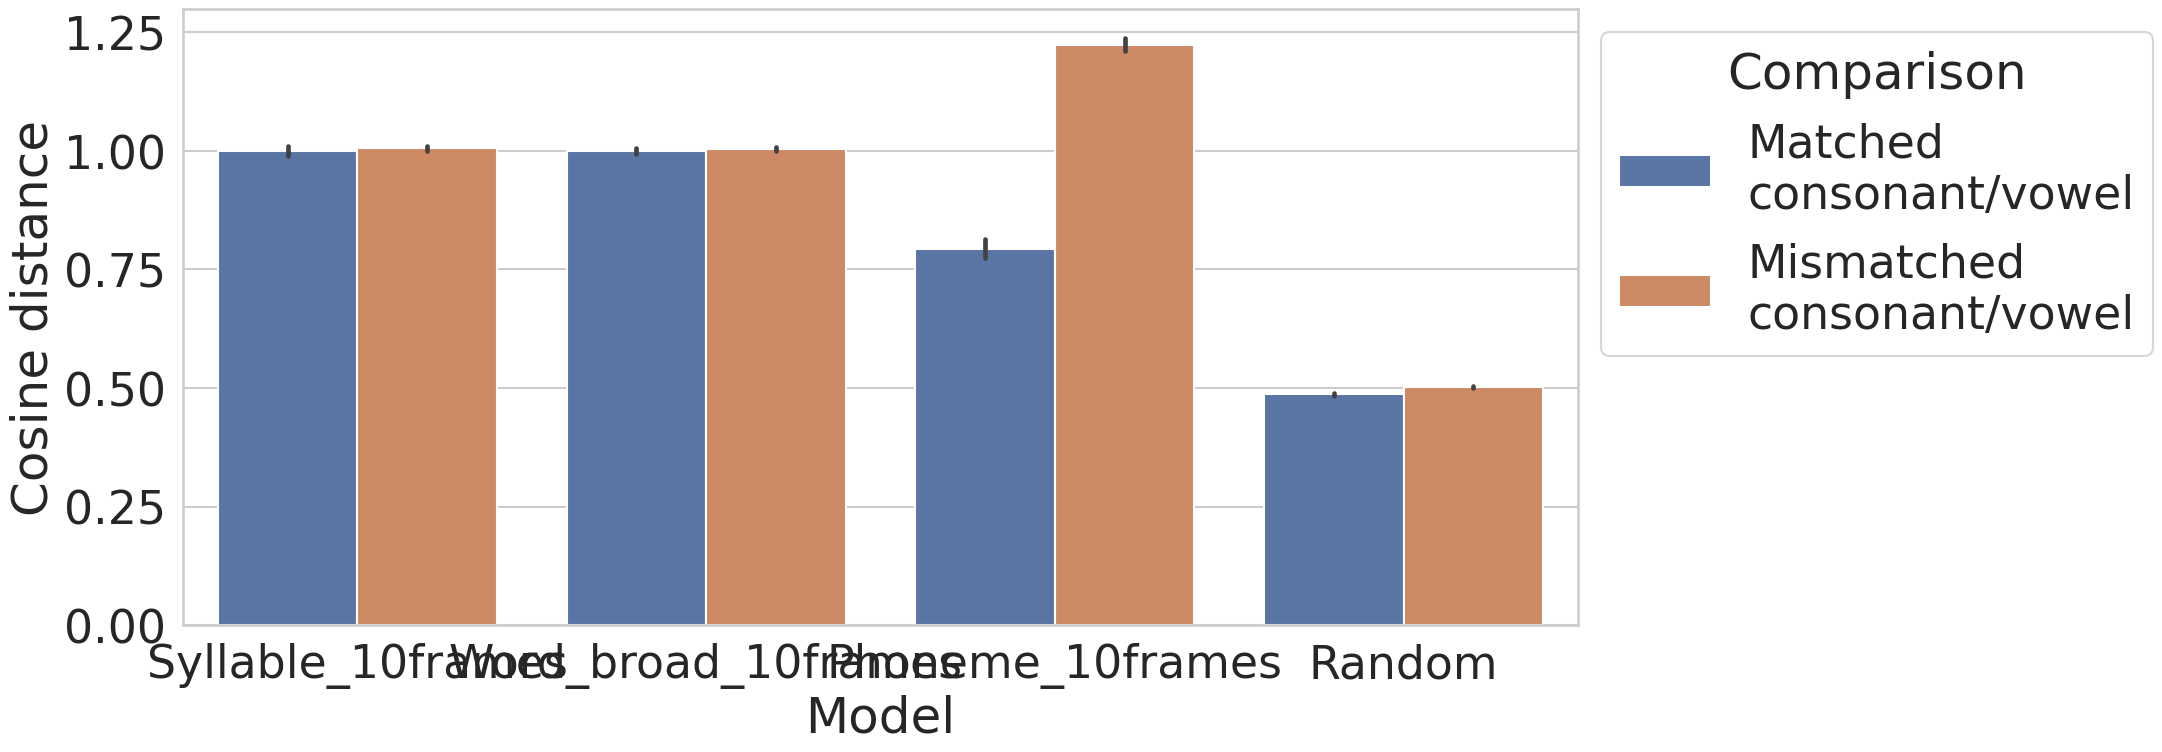

In [53]:
f, ax = plt.subplots(figsize=(18, 8))
phoneme_plot_data = phoneme_distance_by_cv_df.reset_index()
phoneme_plot_data["equivalence"] = phoneme_plot_data["equivalence"].str.capitalize()
phoneme_plot_data["type"] = phoneme_plot_data["type"].map(
    {"within": "Matched\nconsonant/vowel",
     "between": "Mismatched\nconsonant/vowel"}
)
sns.barplot(data=phoneme_plot_data,
            x="equivalence", y="distance", hue="type", ax=ax)

ax.set_ylabel("Cosine distance")
ax.set_xlabel("Model")
ax.legend(title="Comparison", loc="upper left", bbox_to_anchor=(1, 1))

## Syllable-level coherence

In [54]:
syll_distance_by_position_df = load_grouped_distances("**/syllable_coherence_by_position/distances.csv", plot_model_classes, plot_equivalences, min_contrast_instances=100)

In [55]:
syll_distance_by_position_df["syllable_position"] = syll_distance_by_position_df.syllable.str.split(" ").str[-1].astype(int)

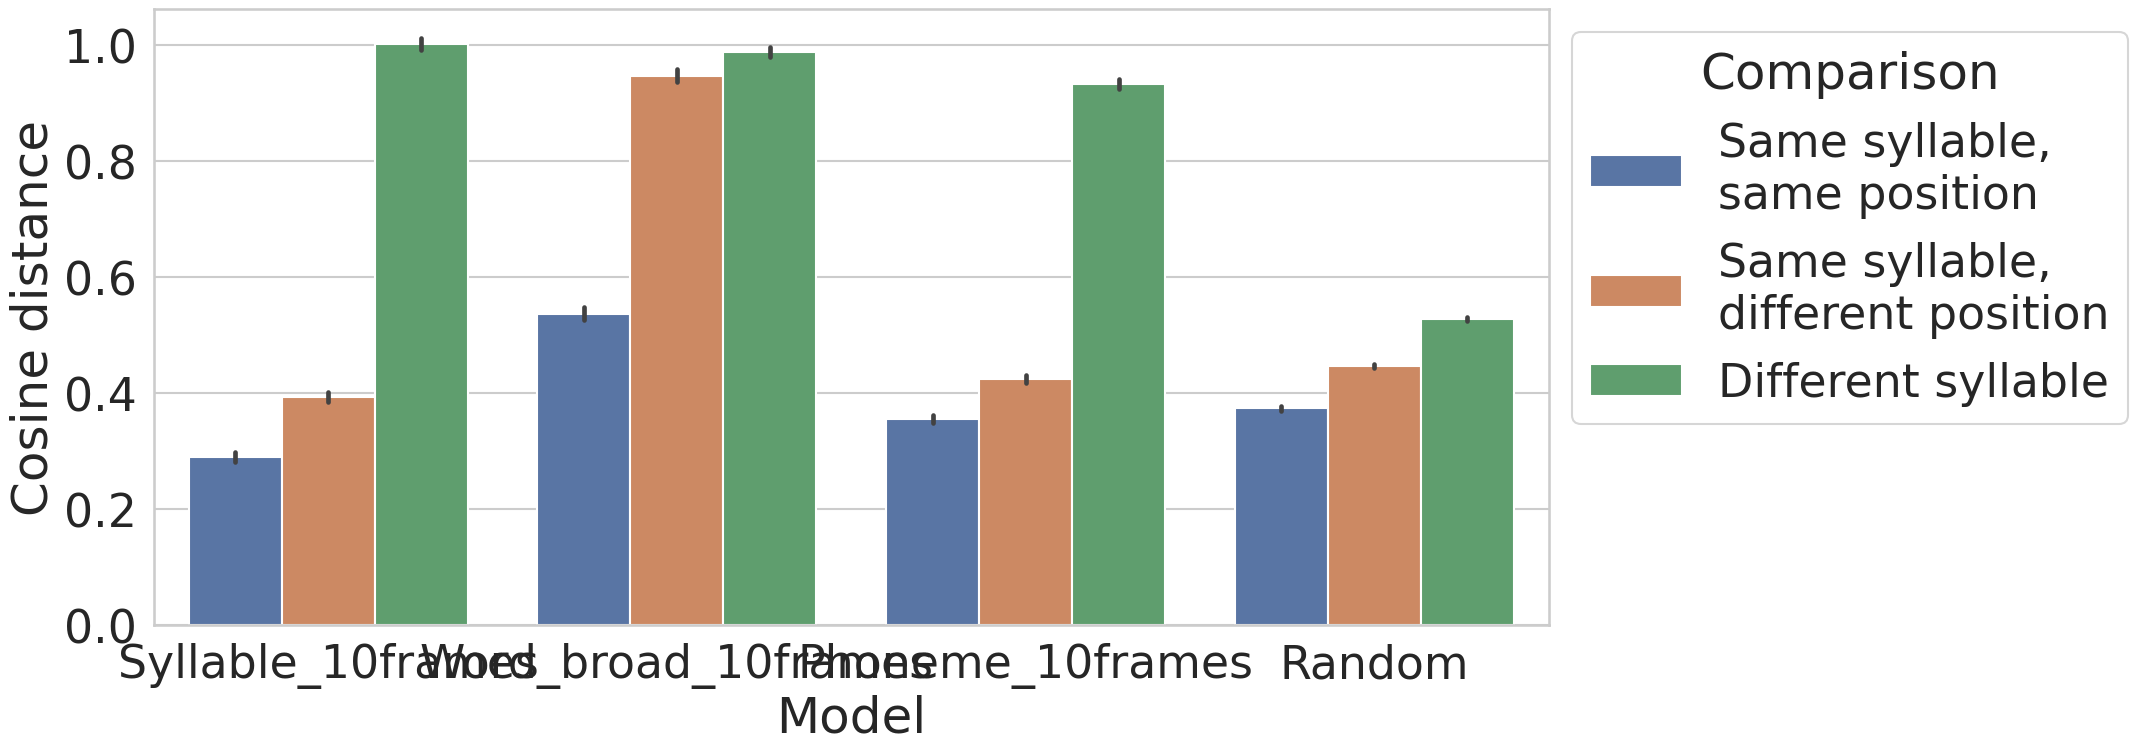

In [56]:
f, ax = plt.subplots(figsize=(18, 8))
syllable_plot_data = syll_distance_by_position_df.reset_index()
syllable_plot_data["equivalence"] = syllable_plot_data["equivalence"].str.capitalize()
syllable_plot_data["type"] = syllable_plot_data["type"].map(
    {"within": "Same syllable,\nsame position",
     "different_position": "Same syllable,\ndifferent position",
     "between": "Different syllable"}
)
sns.barplot(data=syllable_plot_data,#[syllable_plot_data.syllable_position],
            x="equivalence", y="distance", hue="type", ax=ax)

ax.set_ylabel("Cosine distance")
ax.set_xlabel("Model")
ax.legend(title="Comparison", loc="upper left", bbox_to_anchor=(1, 1))

### Grouped by onset

In [57]:
syll_onset_distance_df = load_grouped_distances("**/syllable_coherence/distances-grouped_onset.csv", plot_model_classes, plot_equivalences)
syll_onset_distance_align_offset_df = load_grouped_distances("**/syllable_coherence/distances-grouped_onset_aligned_offset.csv", plot_model_classes, plot_equivalences)

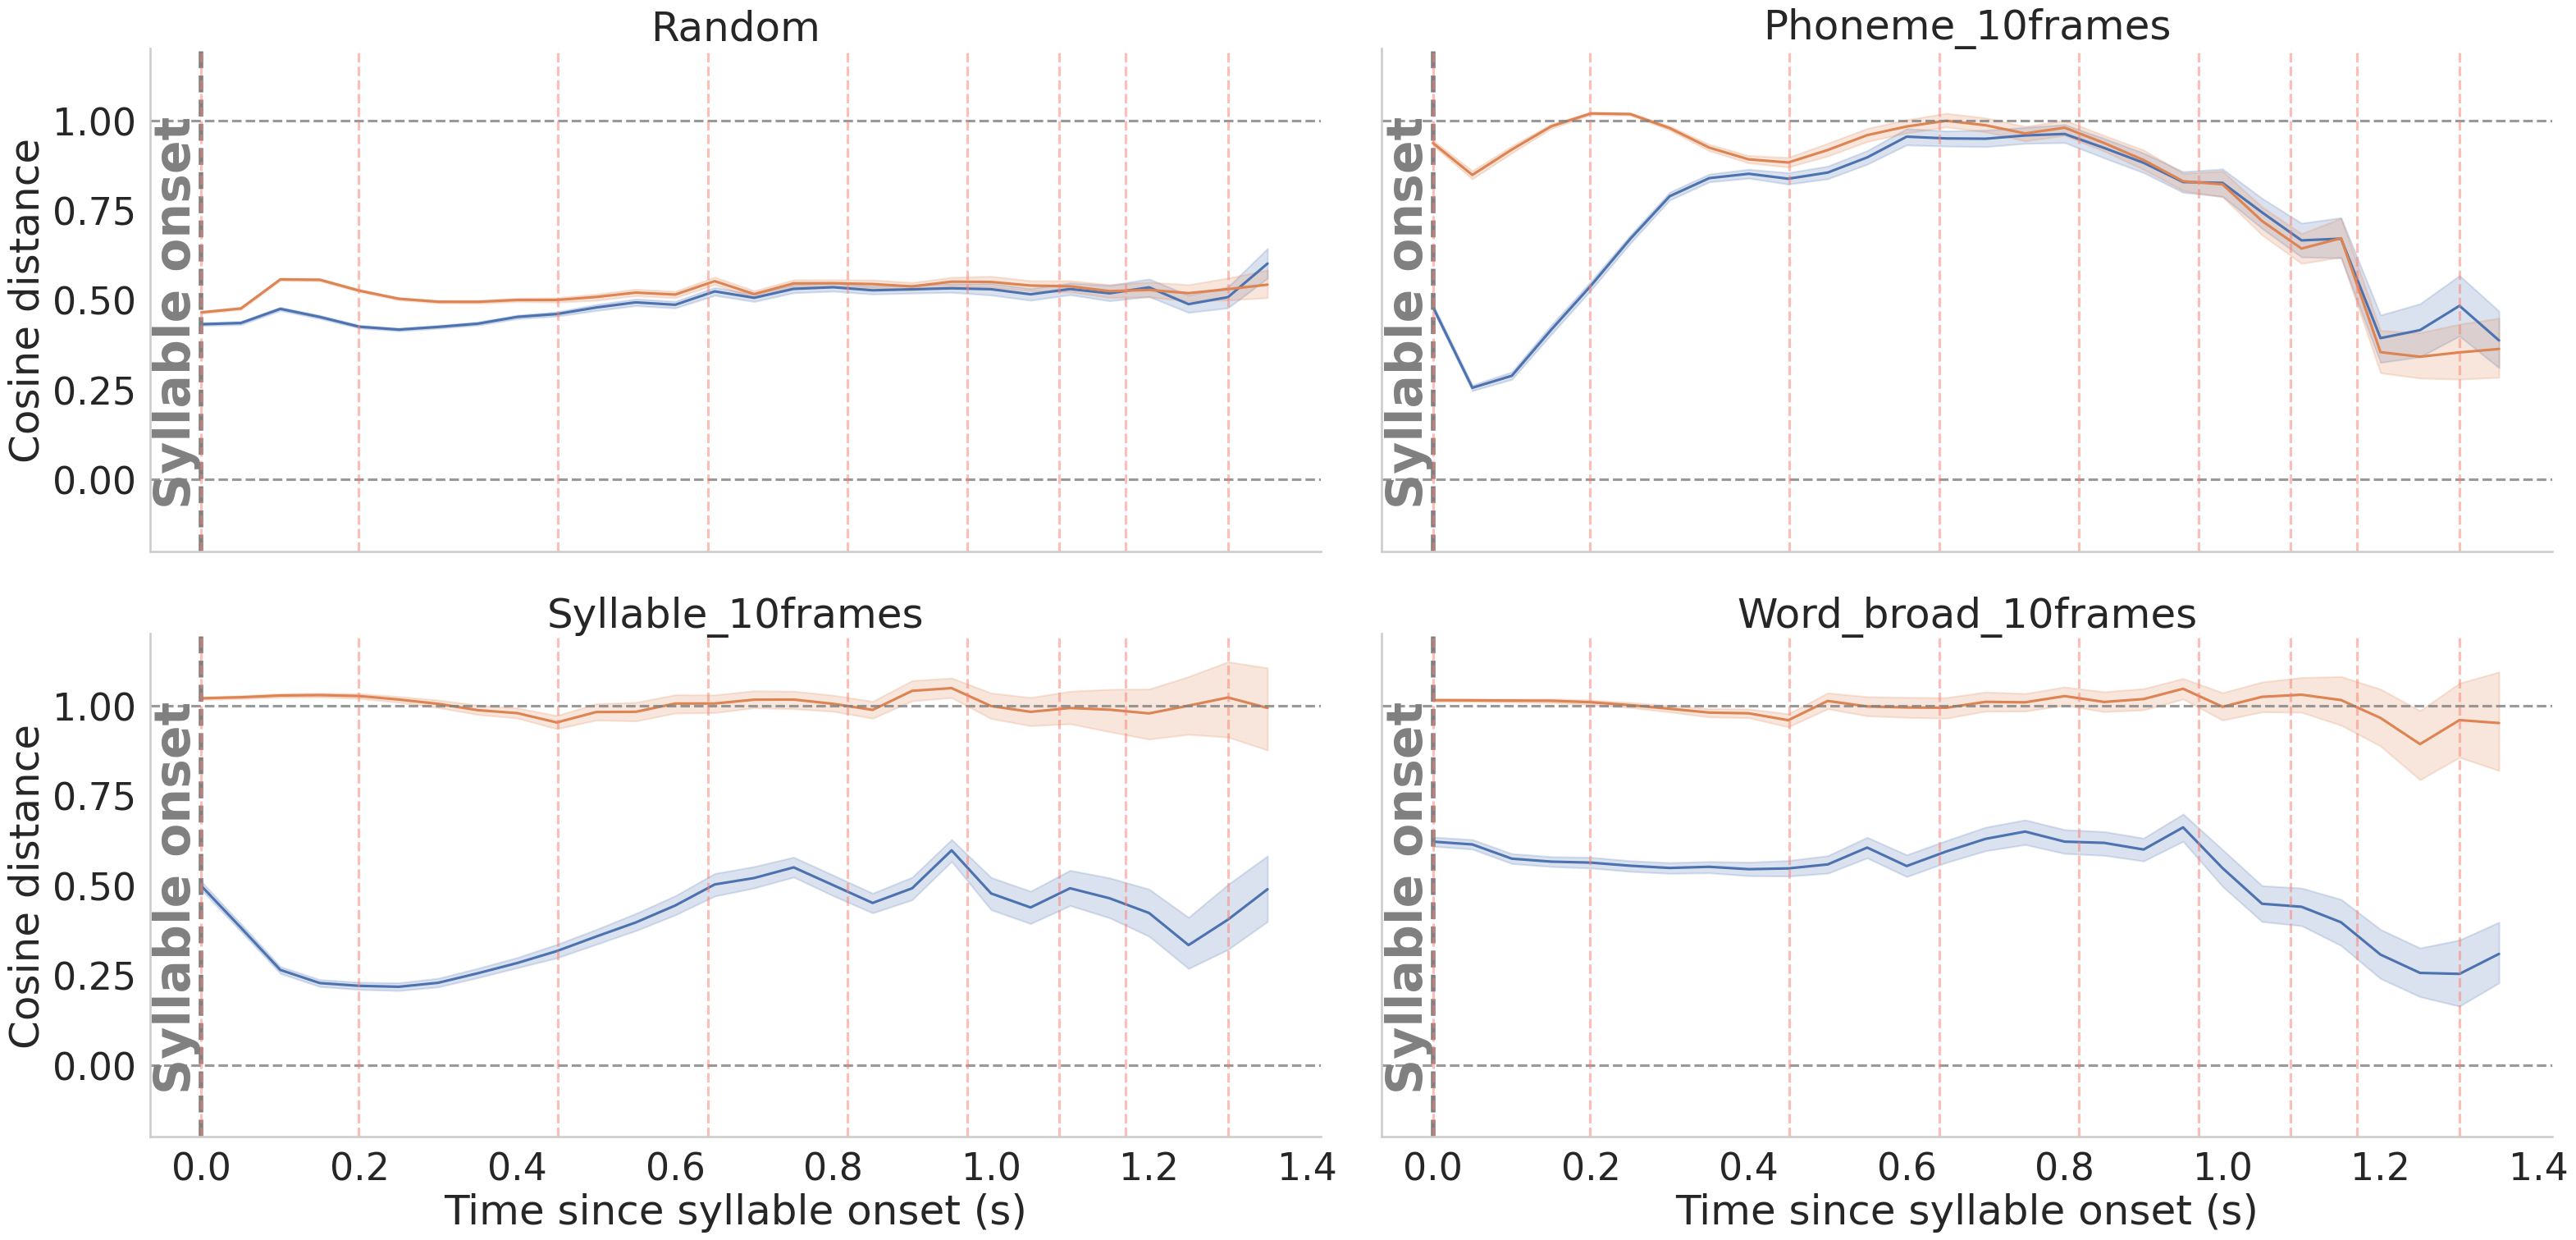

In [58]:
g = plot_coherence(syll_onset_distance_df, "syllable", plot_phonemes=phoneme_in_syllable_mean_onsets)

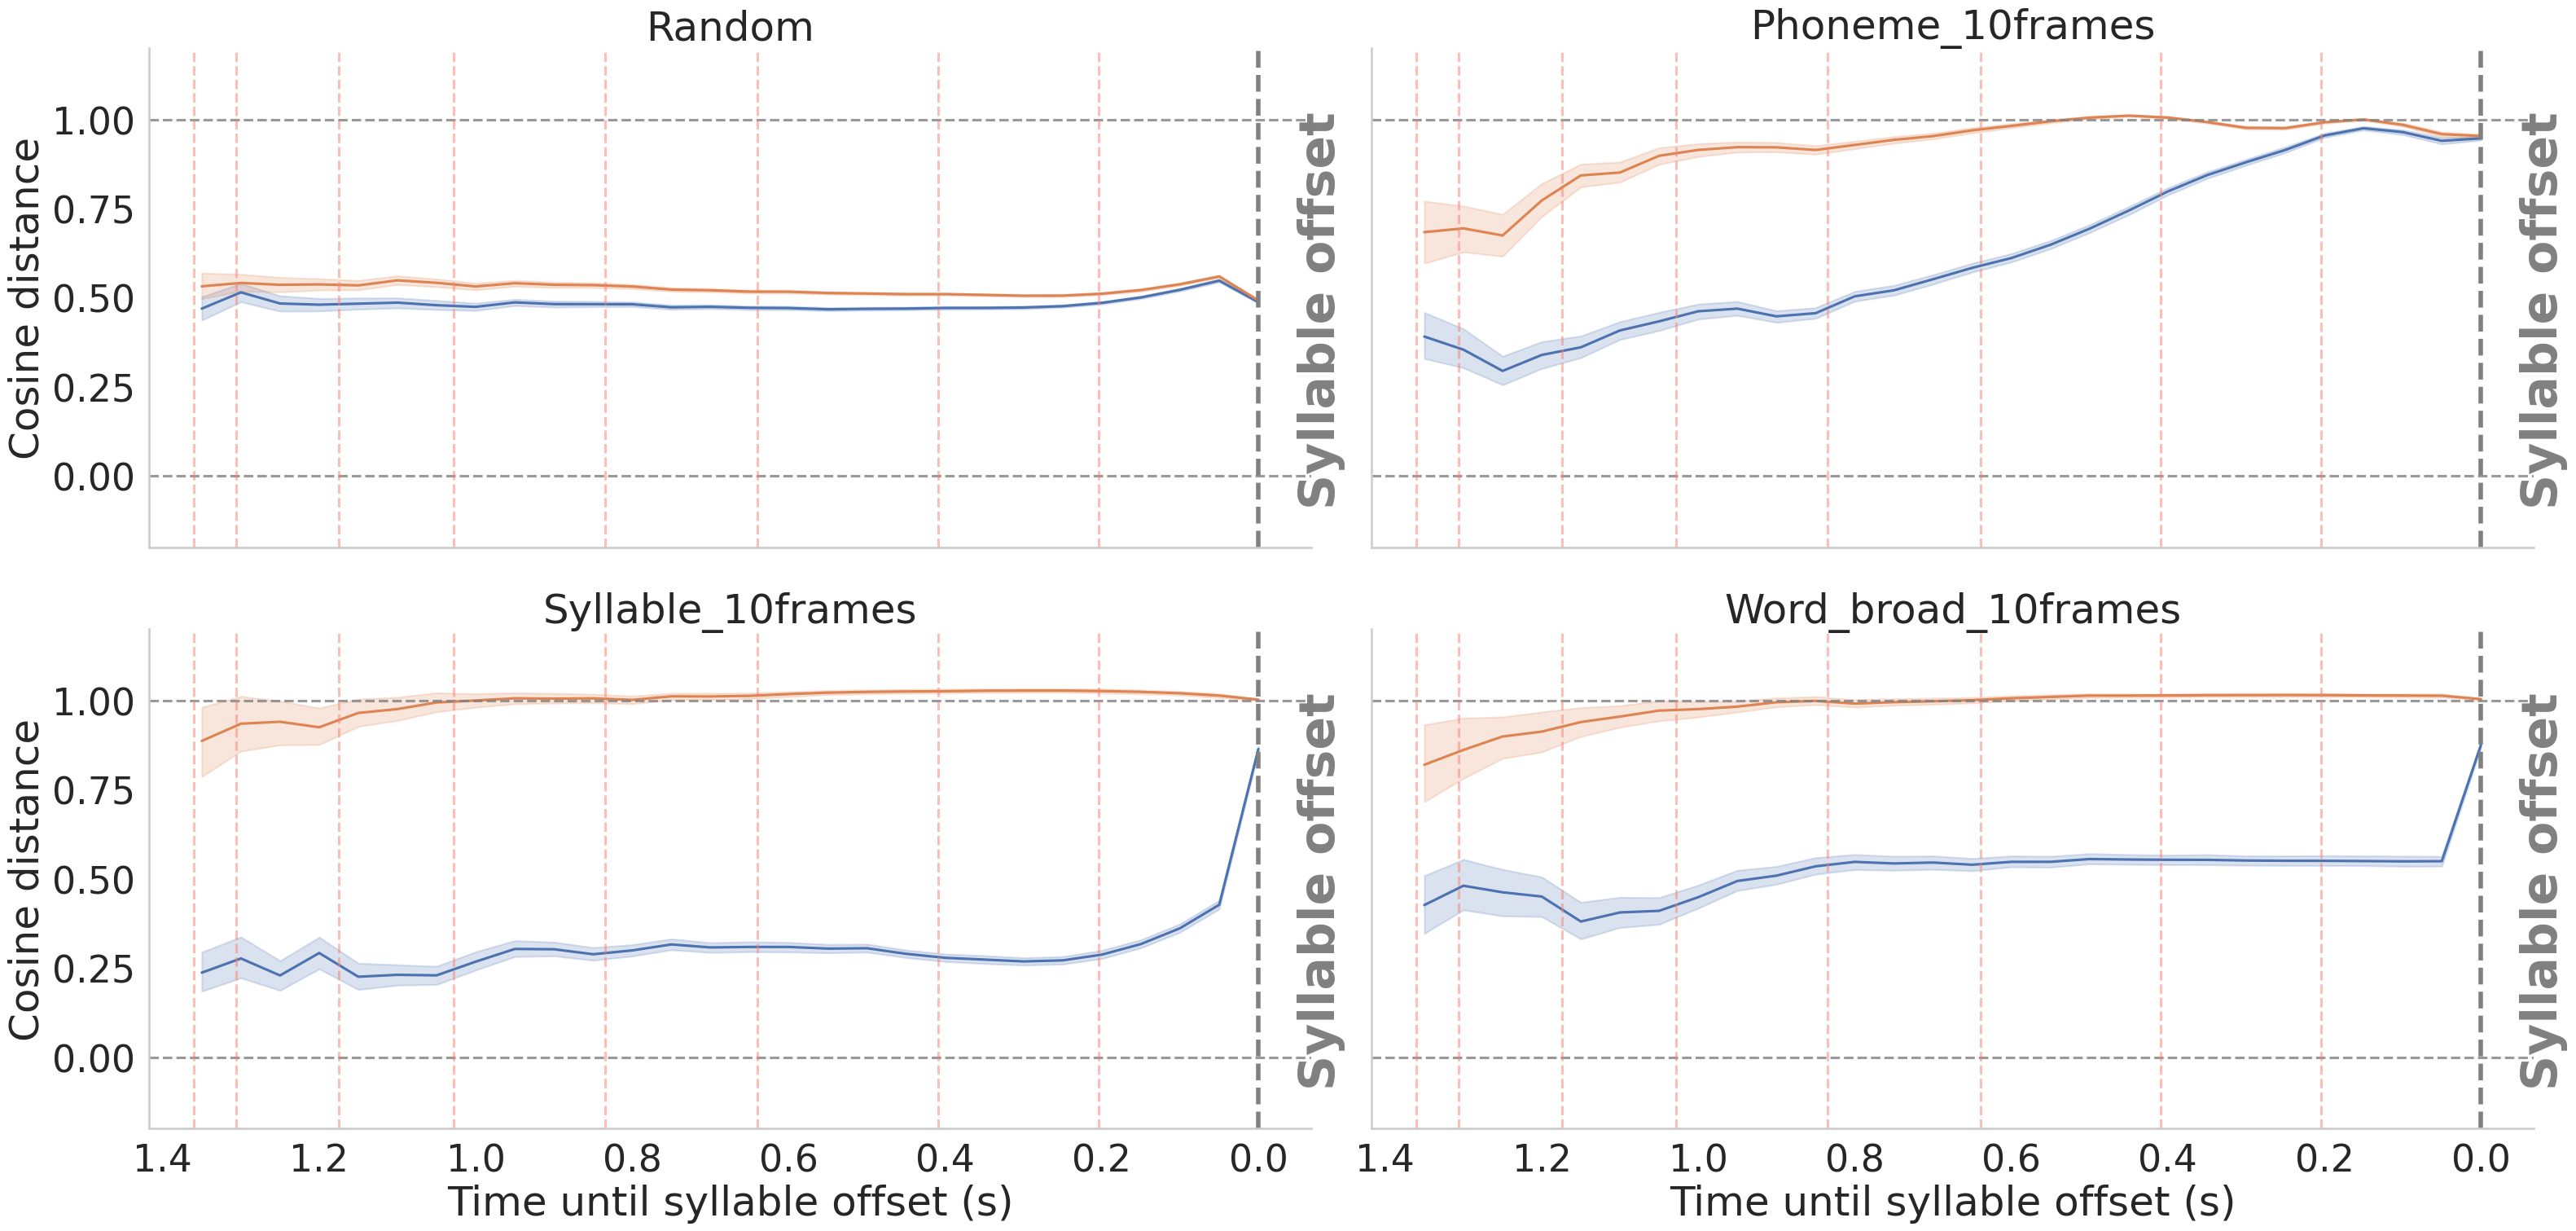

In [59]:
g = plot_coherence(syll_onset_distance_align_offset_df, "syllable", alignment="offset",
                   plot_phonemes=phoneme_in_syllable_reverse_mean_onsets)

### Grouped by nucleus

In [60]:
syll_nucleus_distance_df = load_grouped_distances("**/syllable_coherence/distances-grouped_nucleus.csv", plot_model_classes, plot_equivalences)
syll_nucleus_distance_align_offset_df = load_grouped_distances("**/syllable_coherence/distances-grouped_nucleus_aligned_offset.csv", plot_model_classes, plot_equivalences)

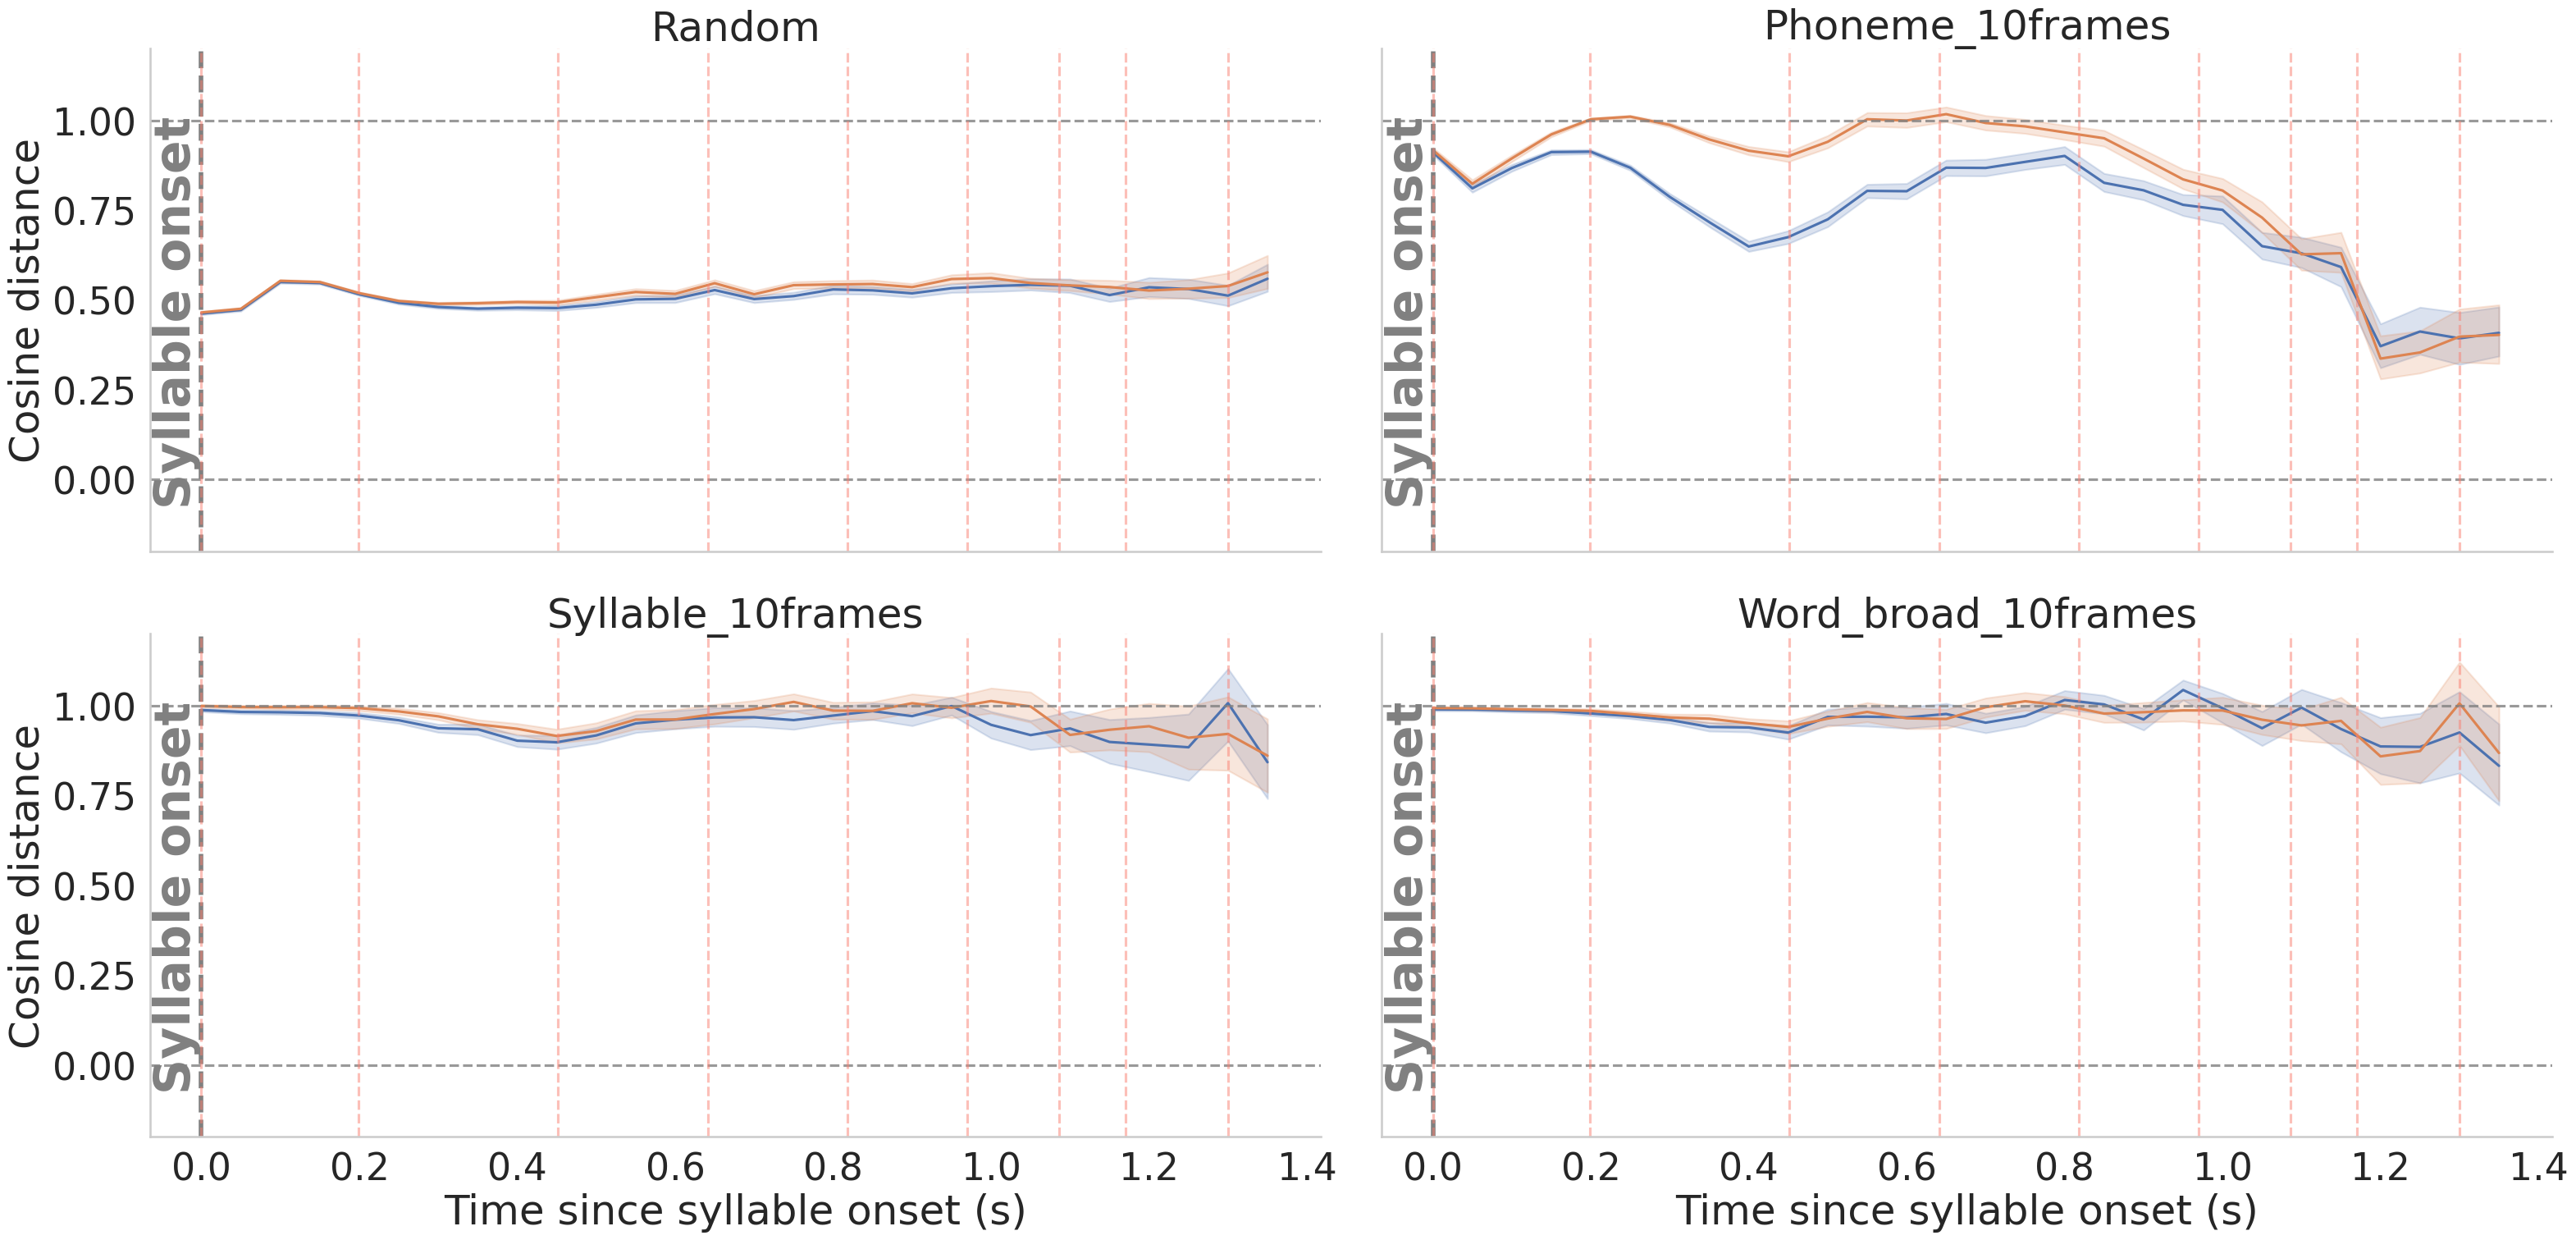

In [61]:
plot_coherence(syll_nucleus_distance_df, "syllable", plot_phonemes=phoneme_in_syllable_mean_onsets)

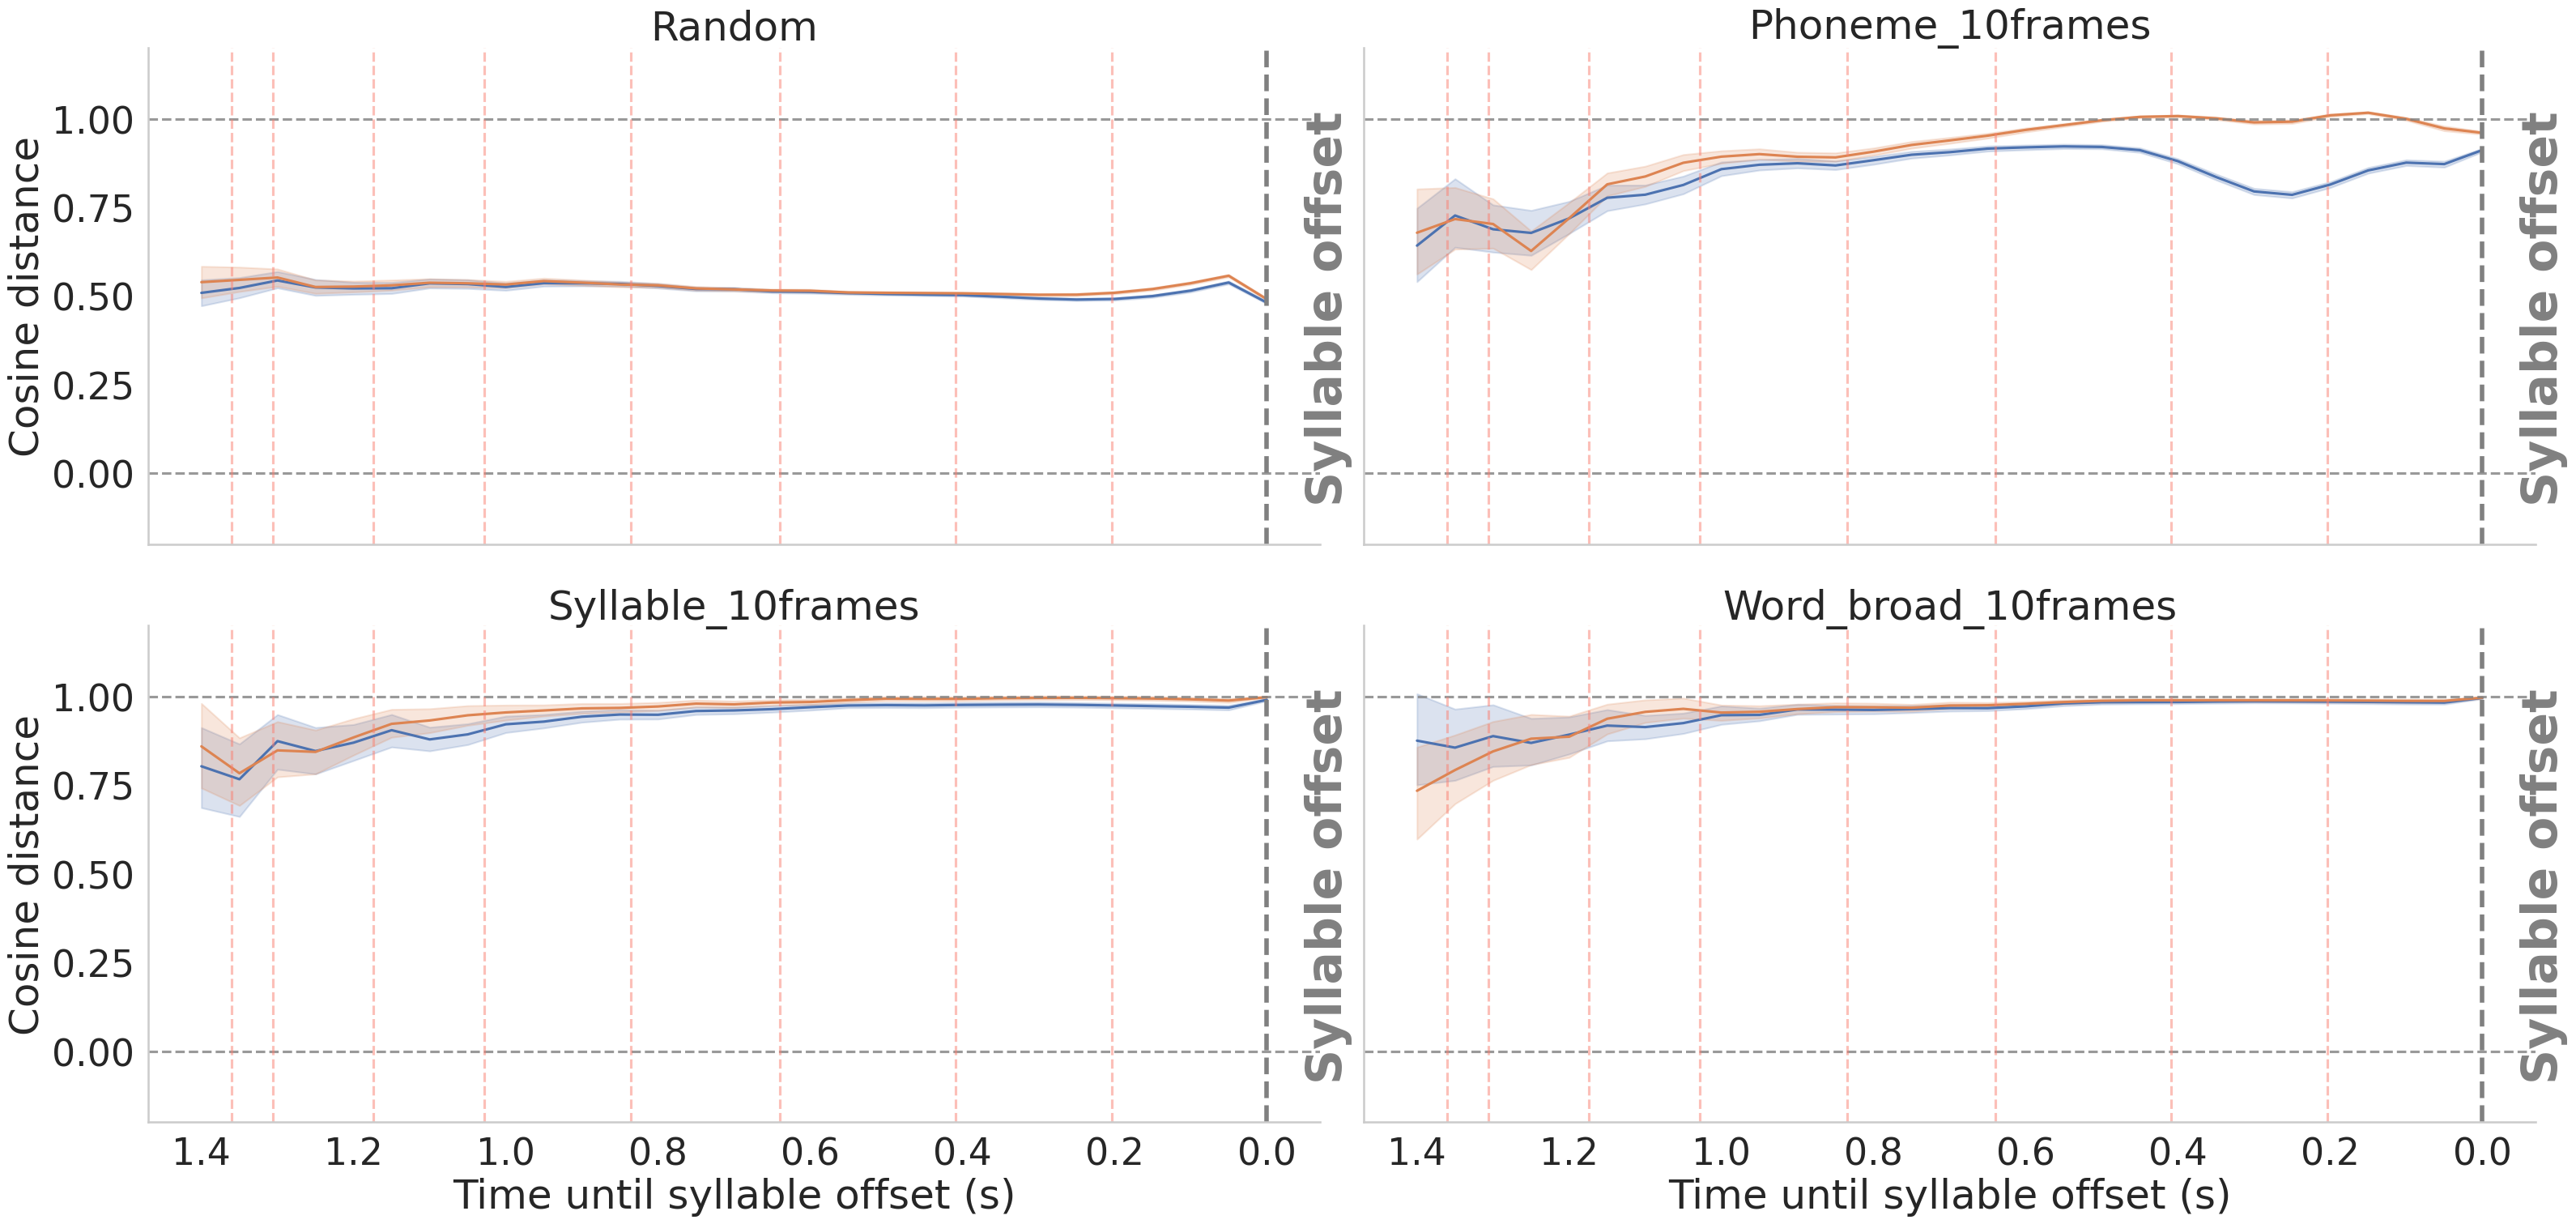

In [62]:
plot_coherence(syll_nucleus_distance_align_offset_df, "syllable", alignment="offset",
               plot_phonemes=phoneme_in_syllable_reverse_mean_onsets)

### Onset vs. nucleus

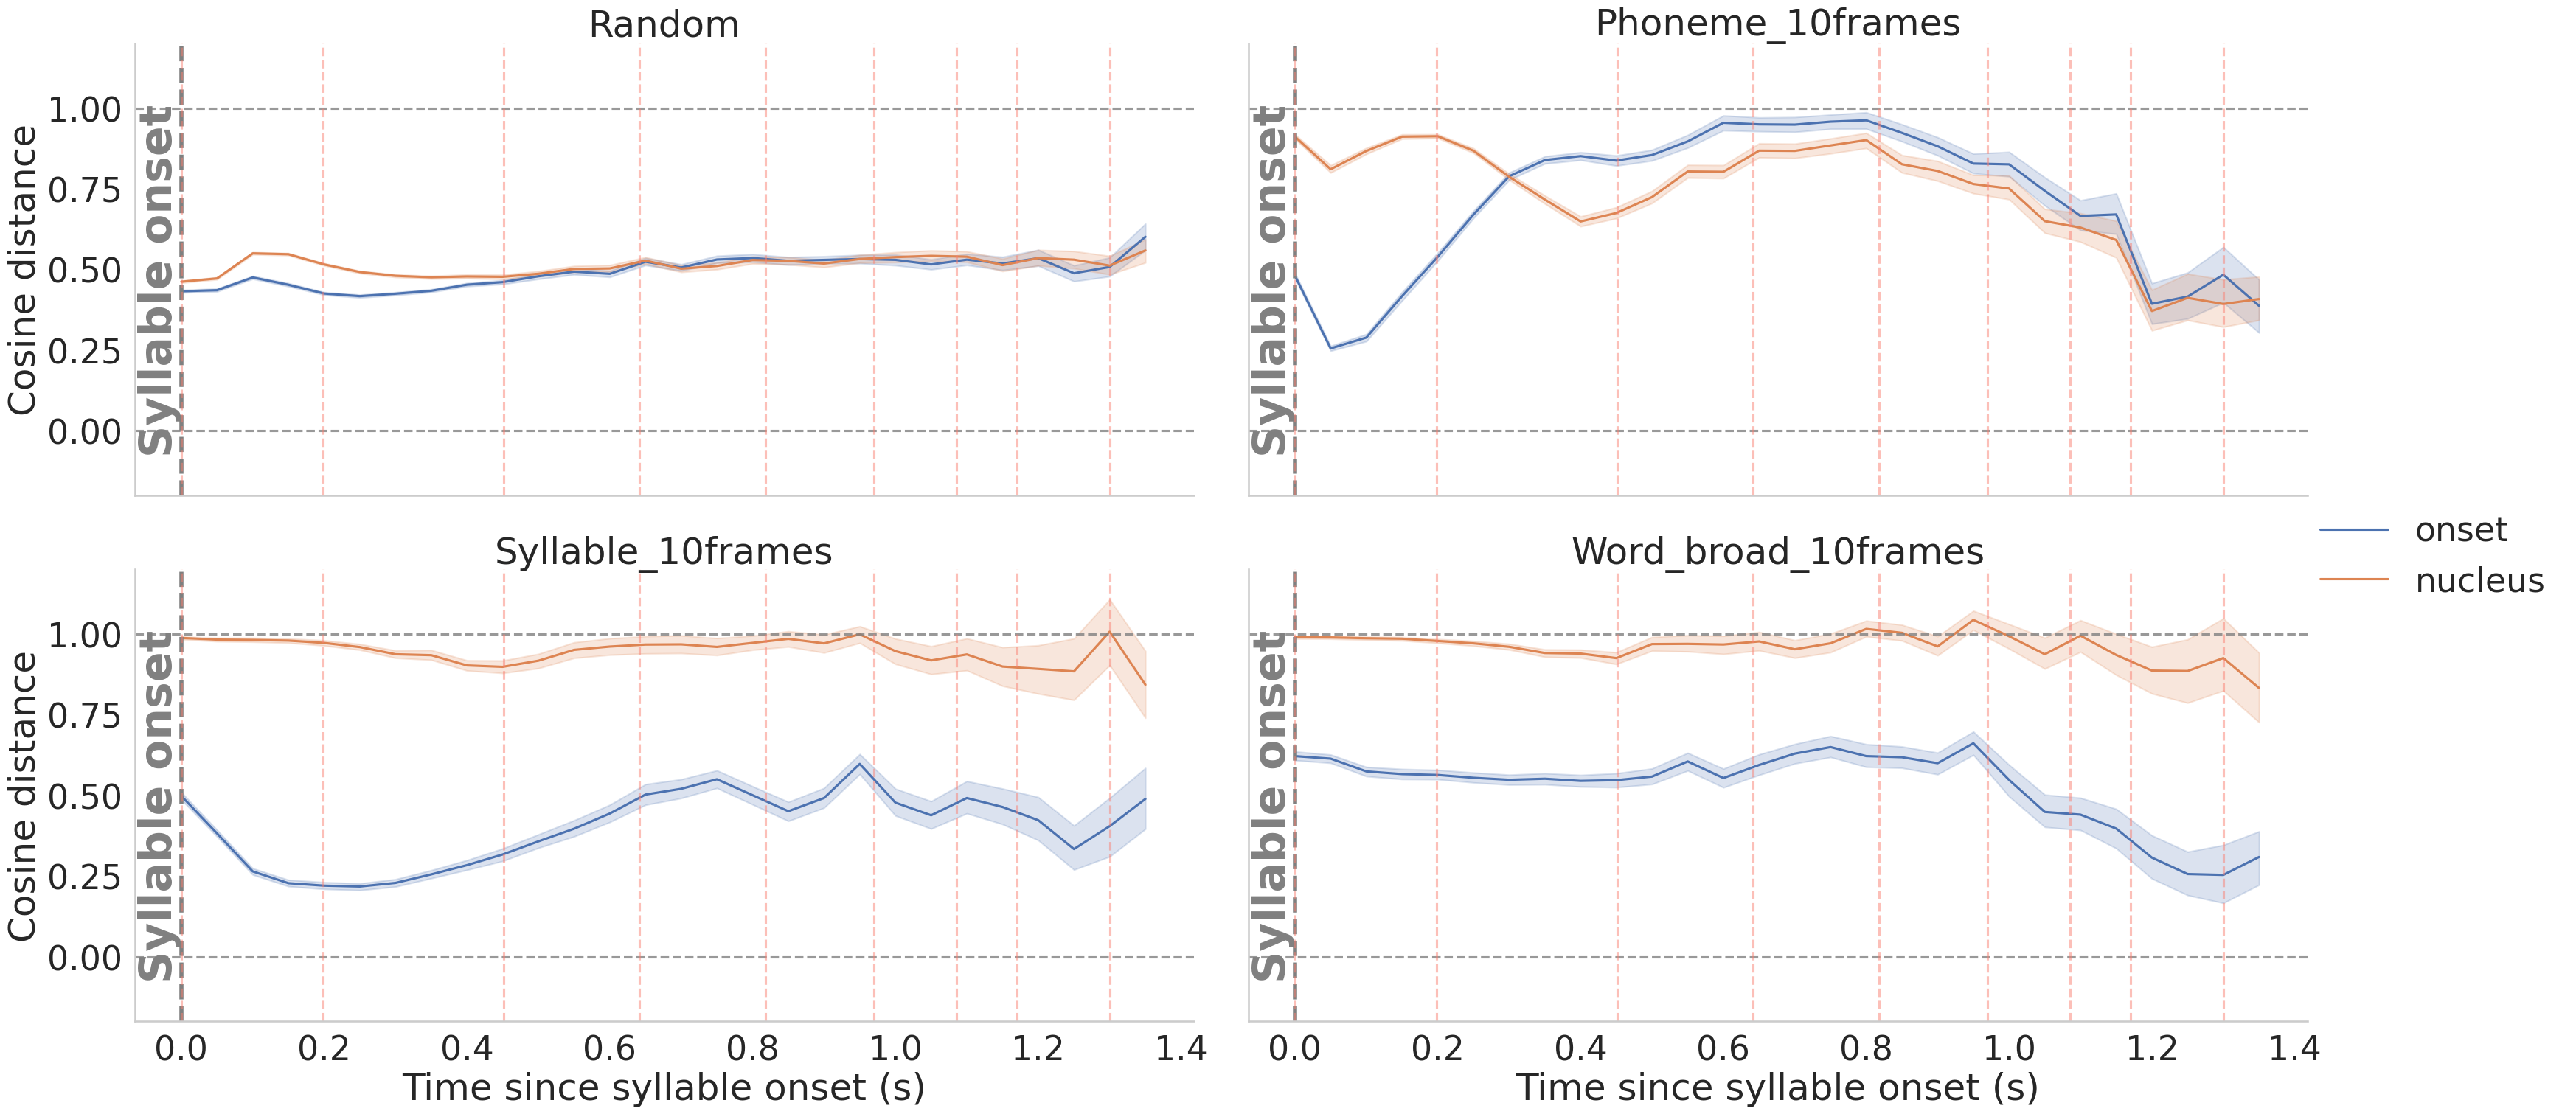

In [63]:
syll_merged_df = pd.concat([syll_onset_distance_df, syll_nucleus_distance_df], keys=["onset", "nucleus"], names=["match_type"])
syll_merged_df = syll_merged_df[syll_merged_df.type == "matched"].drop(columns="type").reset_index(level="match_type").rename(columns={"match_type": "type"})
plot_coherence(syll_merged_df.reset_index(), "syllable", hue_order=["abc", "def", "onset", "nucleus"],
               plot_phonemes=phoneme_in_syllable_mean_onsets, legend=True)

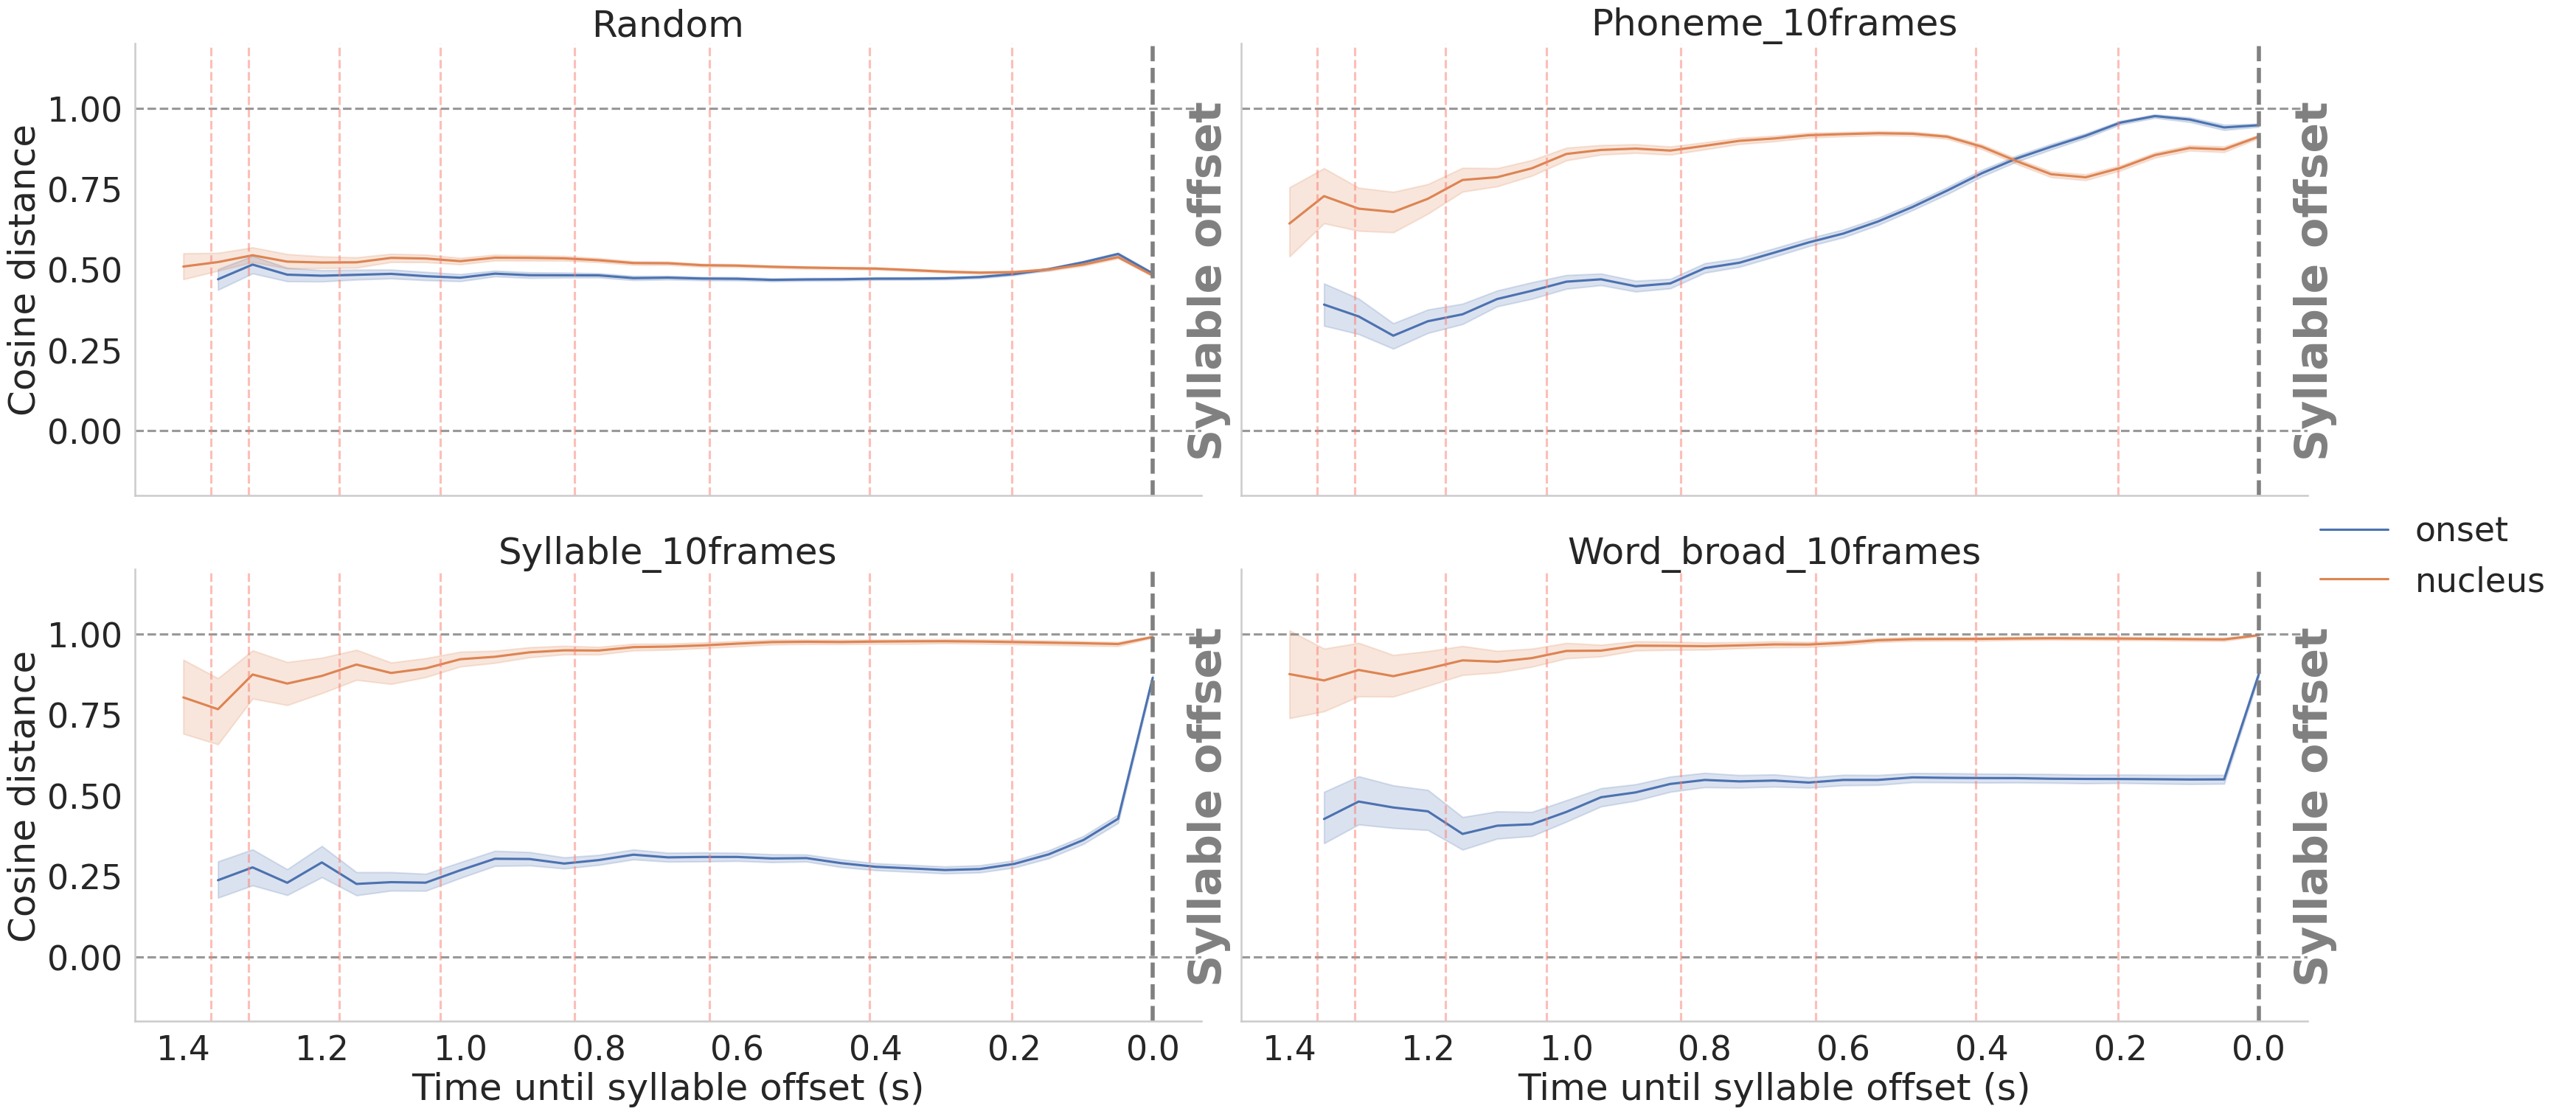

In [64]:
syll_merged_offset_df = pd.concat([syll_onset_distance_align_offset_df, syll_nucleus_distance_align_offset_df], 
                                  keys=["onset", "nucleus"], names=["match_type"])
syll_merged_offset_df = syll_merged_offset_df[syll_merged_offset_df.type == "matched"].drop(columns="type").reset_index(level="match_type").rename(columns={"match_type": "type"})
plot_coherence(syll_merged_offset_df.reset_index(), "syllable", alignment="offset",
               hue_order=["abc", "def", "onset", "nucleus"],
               plot_phonemes=phoneme_in_syllable_reverse_mean_onsets, legend=True)

## Word coherence

In [65]:
word_distance_df = load_grouped_distances("**/lexical_coherence/distances.csv", plot_model_classes, plot_equivalences)
word_distance_align_offset_df = load_grouped_distances("**/lexical_coherence/distances_aligned_offset.csv", plot_model_classes, plot_equivalences)

In [66]:
# DEV
word_distance_df["time"] = word_distance_df["frame"] / 20
word_distance_align_offset_df["time"] = (word_distance_align_offset_df["frame"] - 1) / 20

In [67]:
sorted(word_distance_df.word.unique())[50:]

['become',
 'been',
 'before',
 'began',
 'begin',
 'being',
 'below',
 'best',
 'big',
 'birth',
 'birthday',
 'black',
 'bob',
 'bones',
 'both',
 'bought',
 'bowl',
 'box',
 'boy',
 'breakfast',
 'bright',
 'broken',
 'brother',
 'business',
 'but',
 'buy',
 'by',
 'came',
 'can',
 'carefully',
 'carry',
 'cats',
 'caused',
 'change',
 'changes',
 'charge',
 'cheese',
 'child',
 'children',
 'church',
 'clay',
 'cleaners',
 'clearly',
 'cloth',
 'club',
 'coffee',
 'coincided',
 'colorful',
 'come',
 'comes',
 'common',
 'completely',
 'contains',
 'cory',
 'cost',
 'costumes',
 'could',
 "couldn't",
 'course',
 'cream',
 'critical',
 'curiosity',
 'cut',
 'dark',
 'data',
 'day',
 'deal',
 'dessert',
 'destroy',
 'development',
 'did',
 "didn't",
 'dime',
 'dinner',
 'dirty',
 'disappeared',
 'do',
 'doctor',
 'does',
 'dog',
 "don't",
 'door',
 'down',
 'draw',
 'drop',
 'dry',
 'each',
 'early',
 'easy',
 'eat',
 'eating',
 'economic',
 'edge',
 'eight',
 'either',
 'elm',
 'else

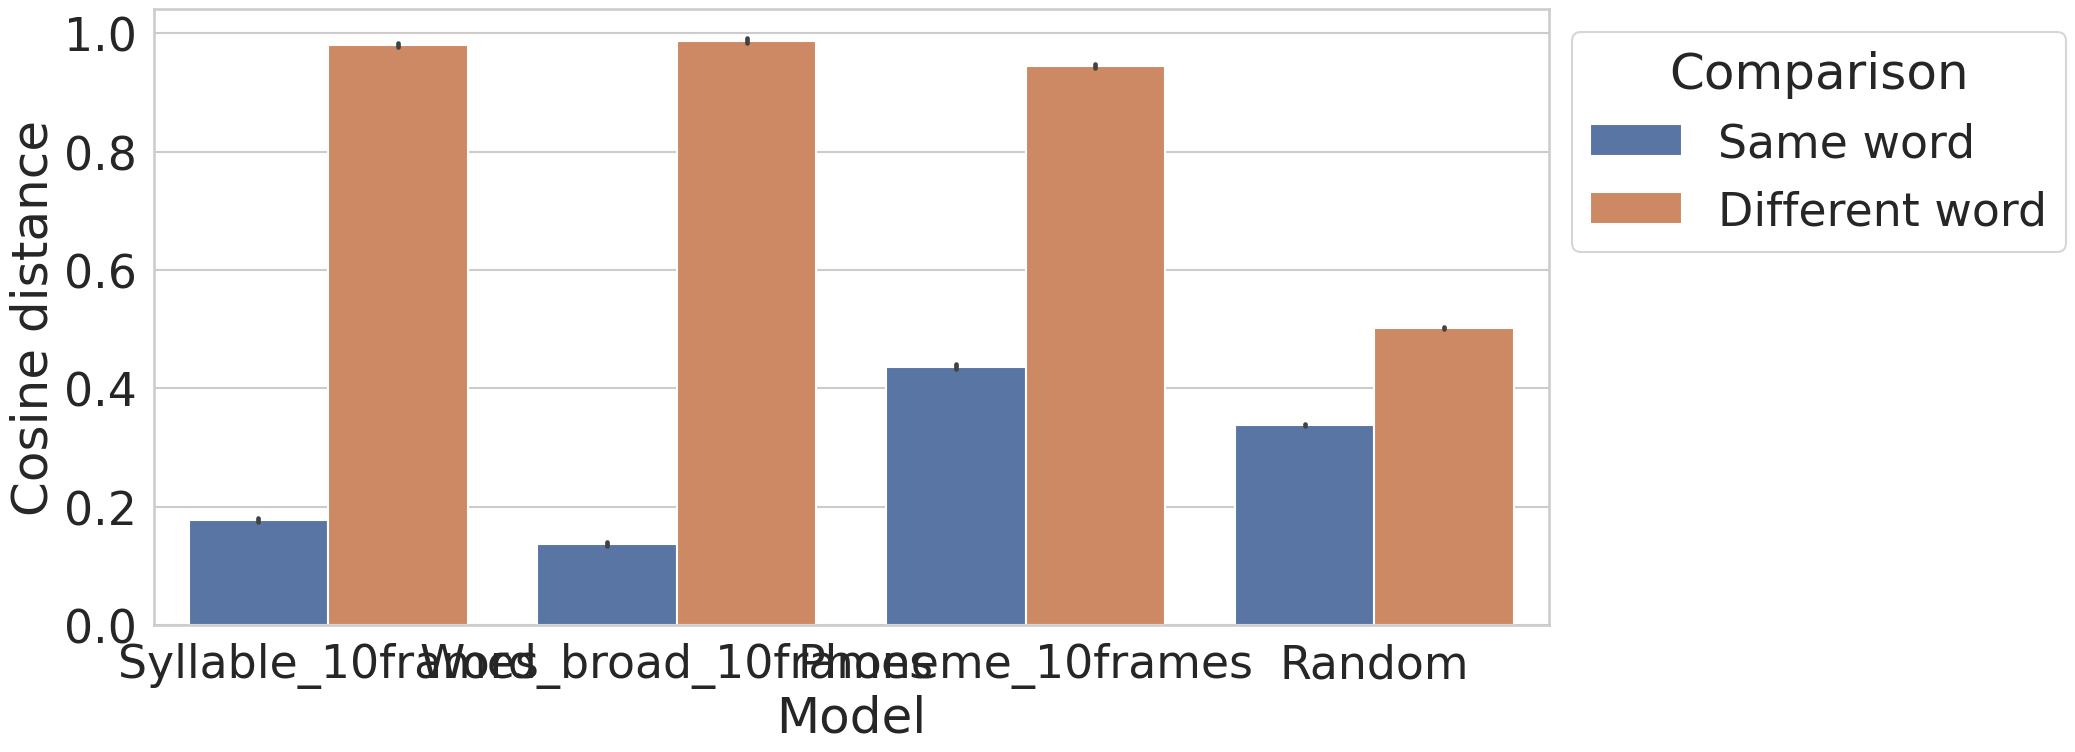

In [68]:
f, ax = plt.subplots(figsize=(18, 8))
word_plot_data = word_distance_df.reset_index()
word_plot_data["equivalence"] = word_plot_data["equivalence"].str.capitalize()
word_plot_data["type"] = word_plot_data["type"].map(
    {"within": "Same word",
     "between": "Different word"}
)
sns.barplot(data=word_plot_data,
            x="equivalence", y="distance", hue="type", ax=ax)

ax.set_ylabel("Cosine distance")
ax.set_xlabel("Model")
ax.legend(title="Comparison", loc="upper left", bbox_to_anchor=(1, 1))

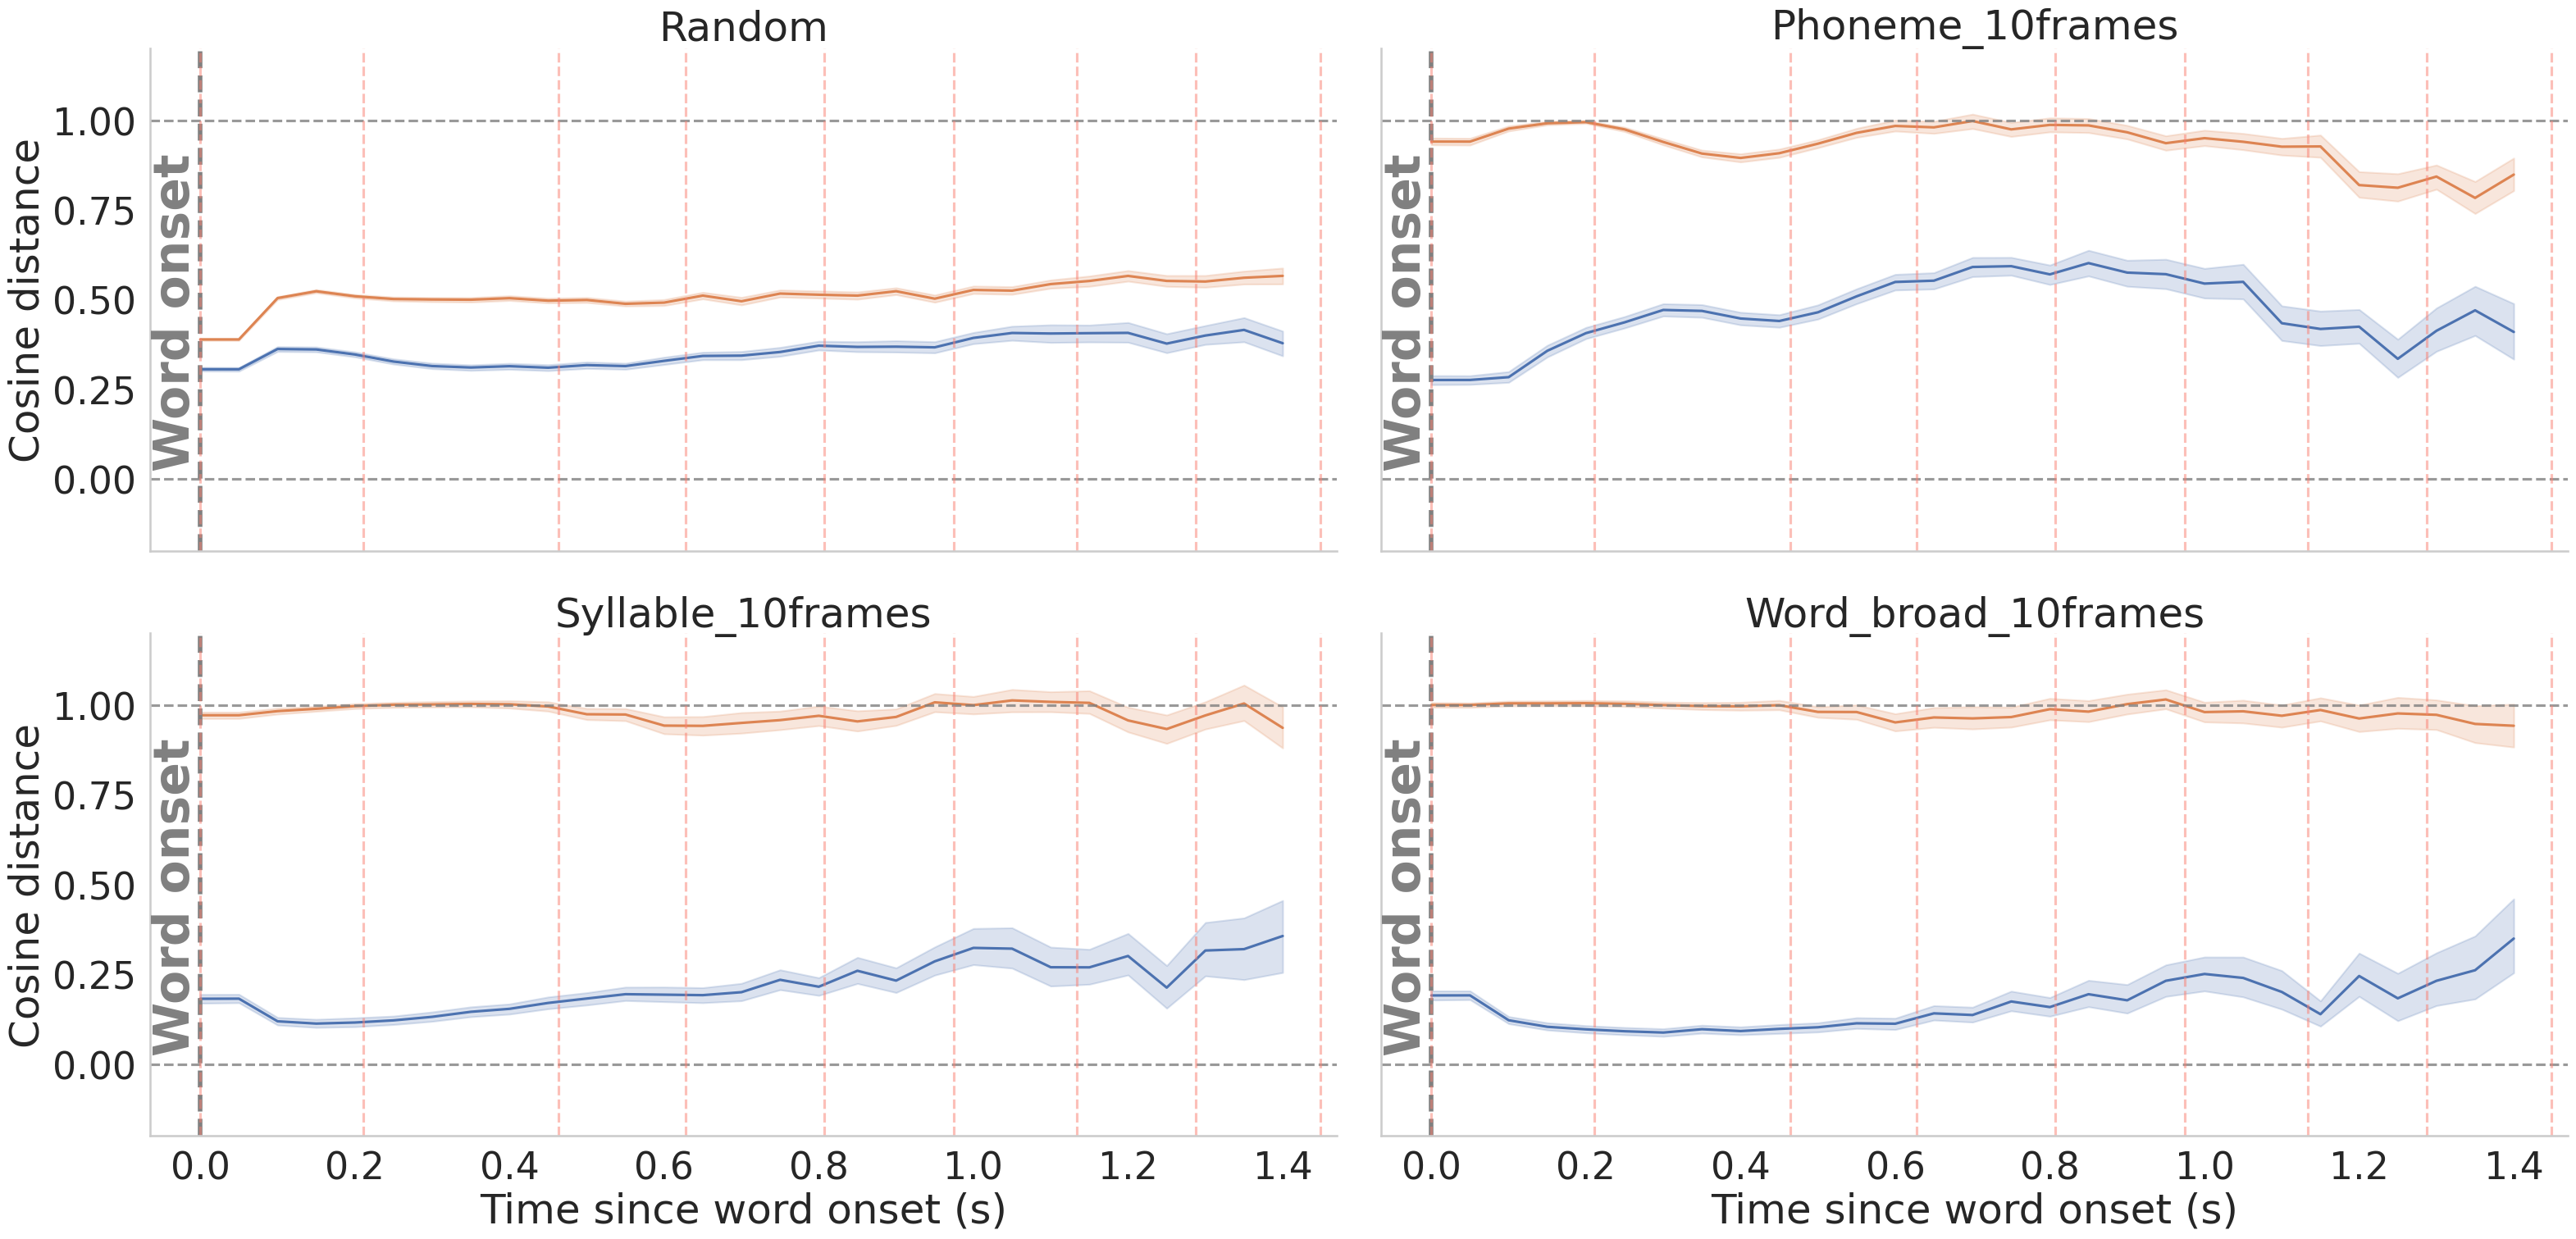

In [69]:
plot_coherence(word_distance_df, "word", plot_phonemes=phoneme_in_word_mean_onsets)

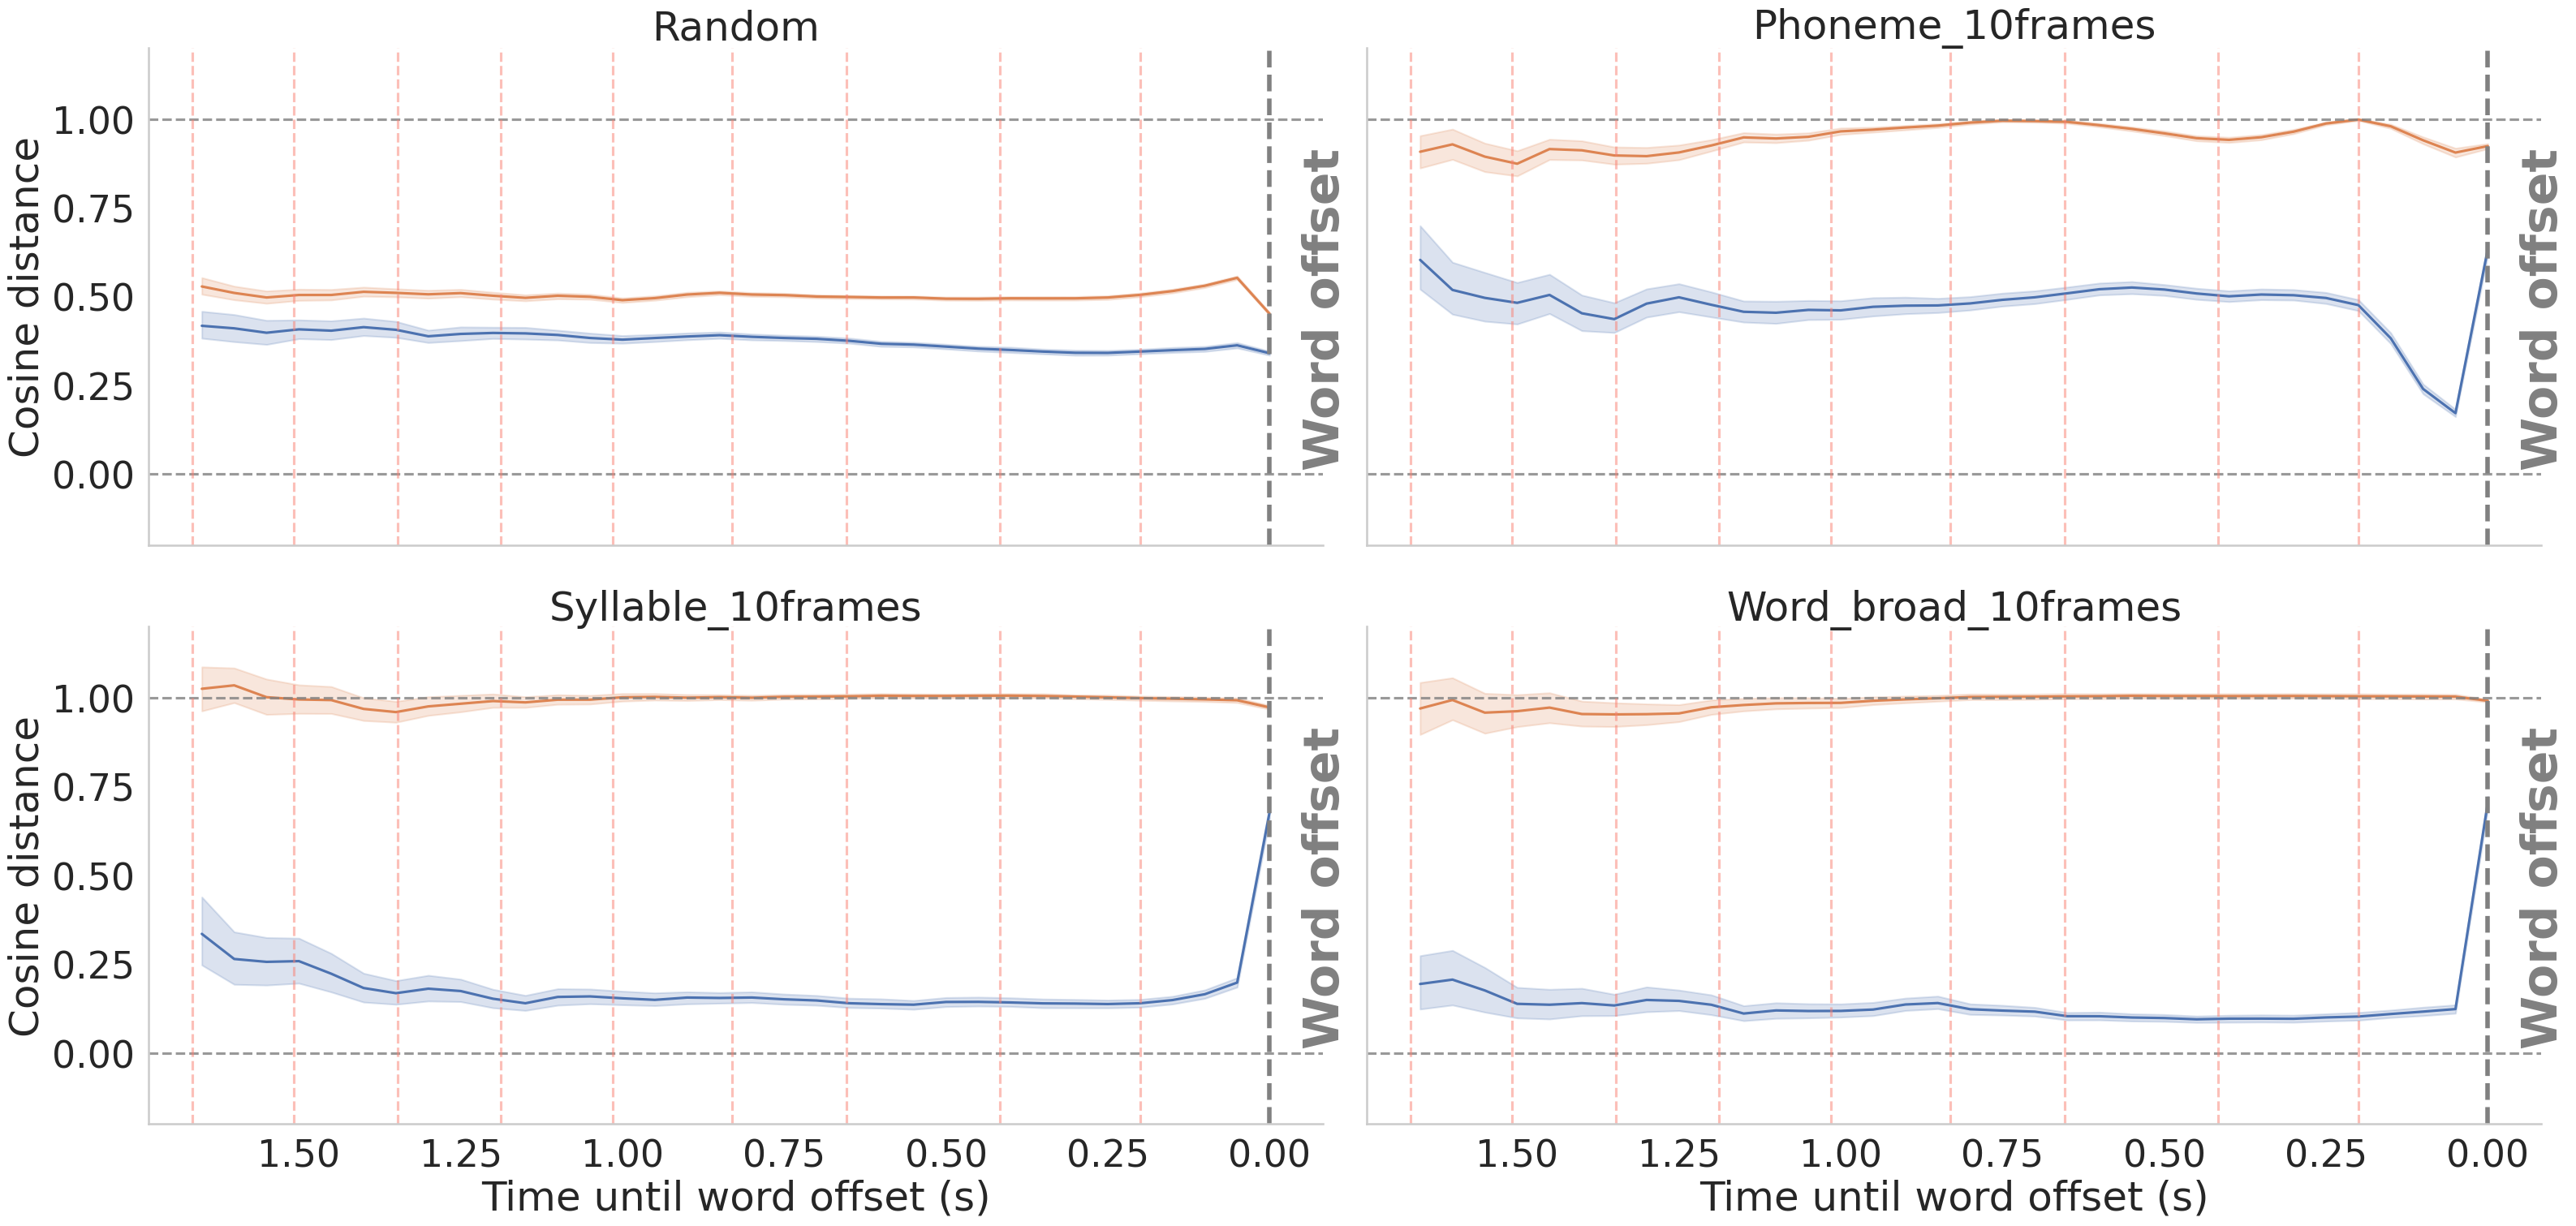

In [70]:
plot_coherence(word_distance_align_offset_df, "word", alignment="offset",
               plot_phonemes=phoneme_in_word_reverse_mean_onsets)

### Grouped by onset

In [71]:
word_onset_distance_df = load_grouped_distances("**/lexical_coherence/distances-grouped_onset.csv", plot_model_classes, plot_equivalences)
word_onset_distance_align_offset_df = load_grouped_distances("**/lexical_coherence/distances-grouped_onset_aligned_offset.csv", plot_model_classes, plot_equivalences)

In [72]:
# DEV
word_onset_distance_df["time"] = word_onset_distance_df["frame"] / 20

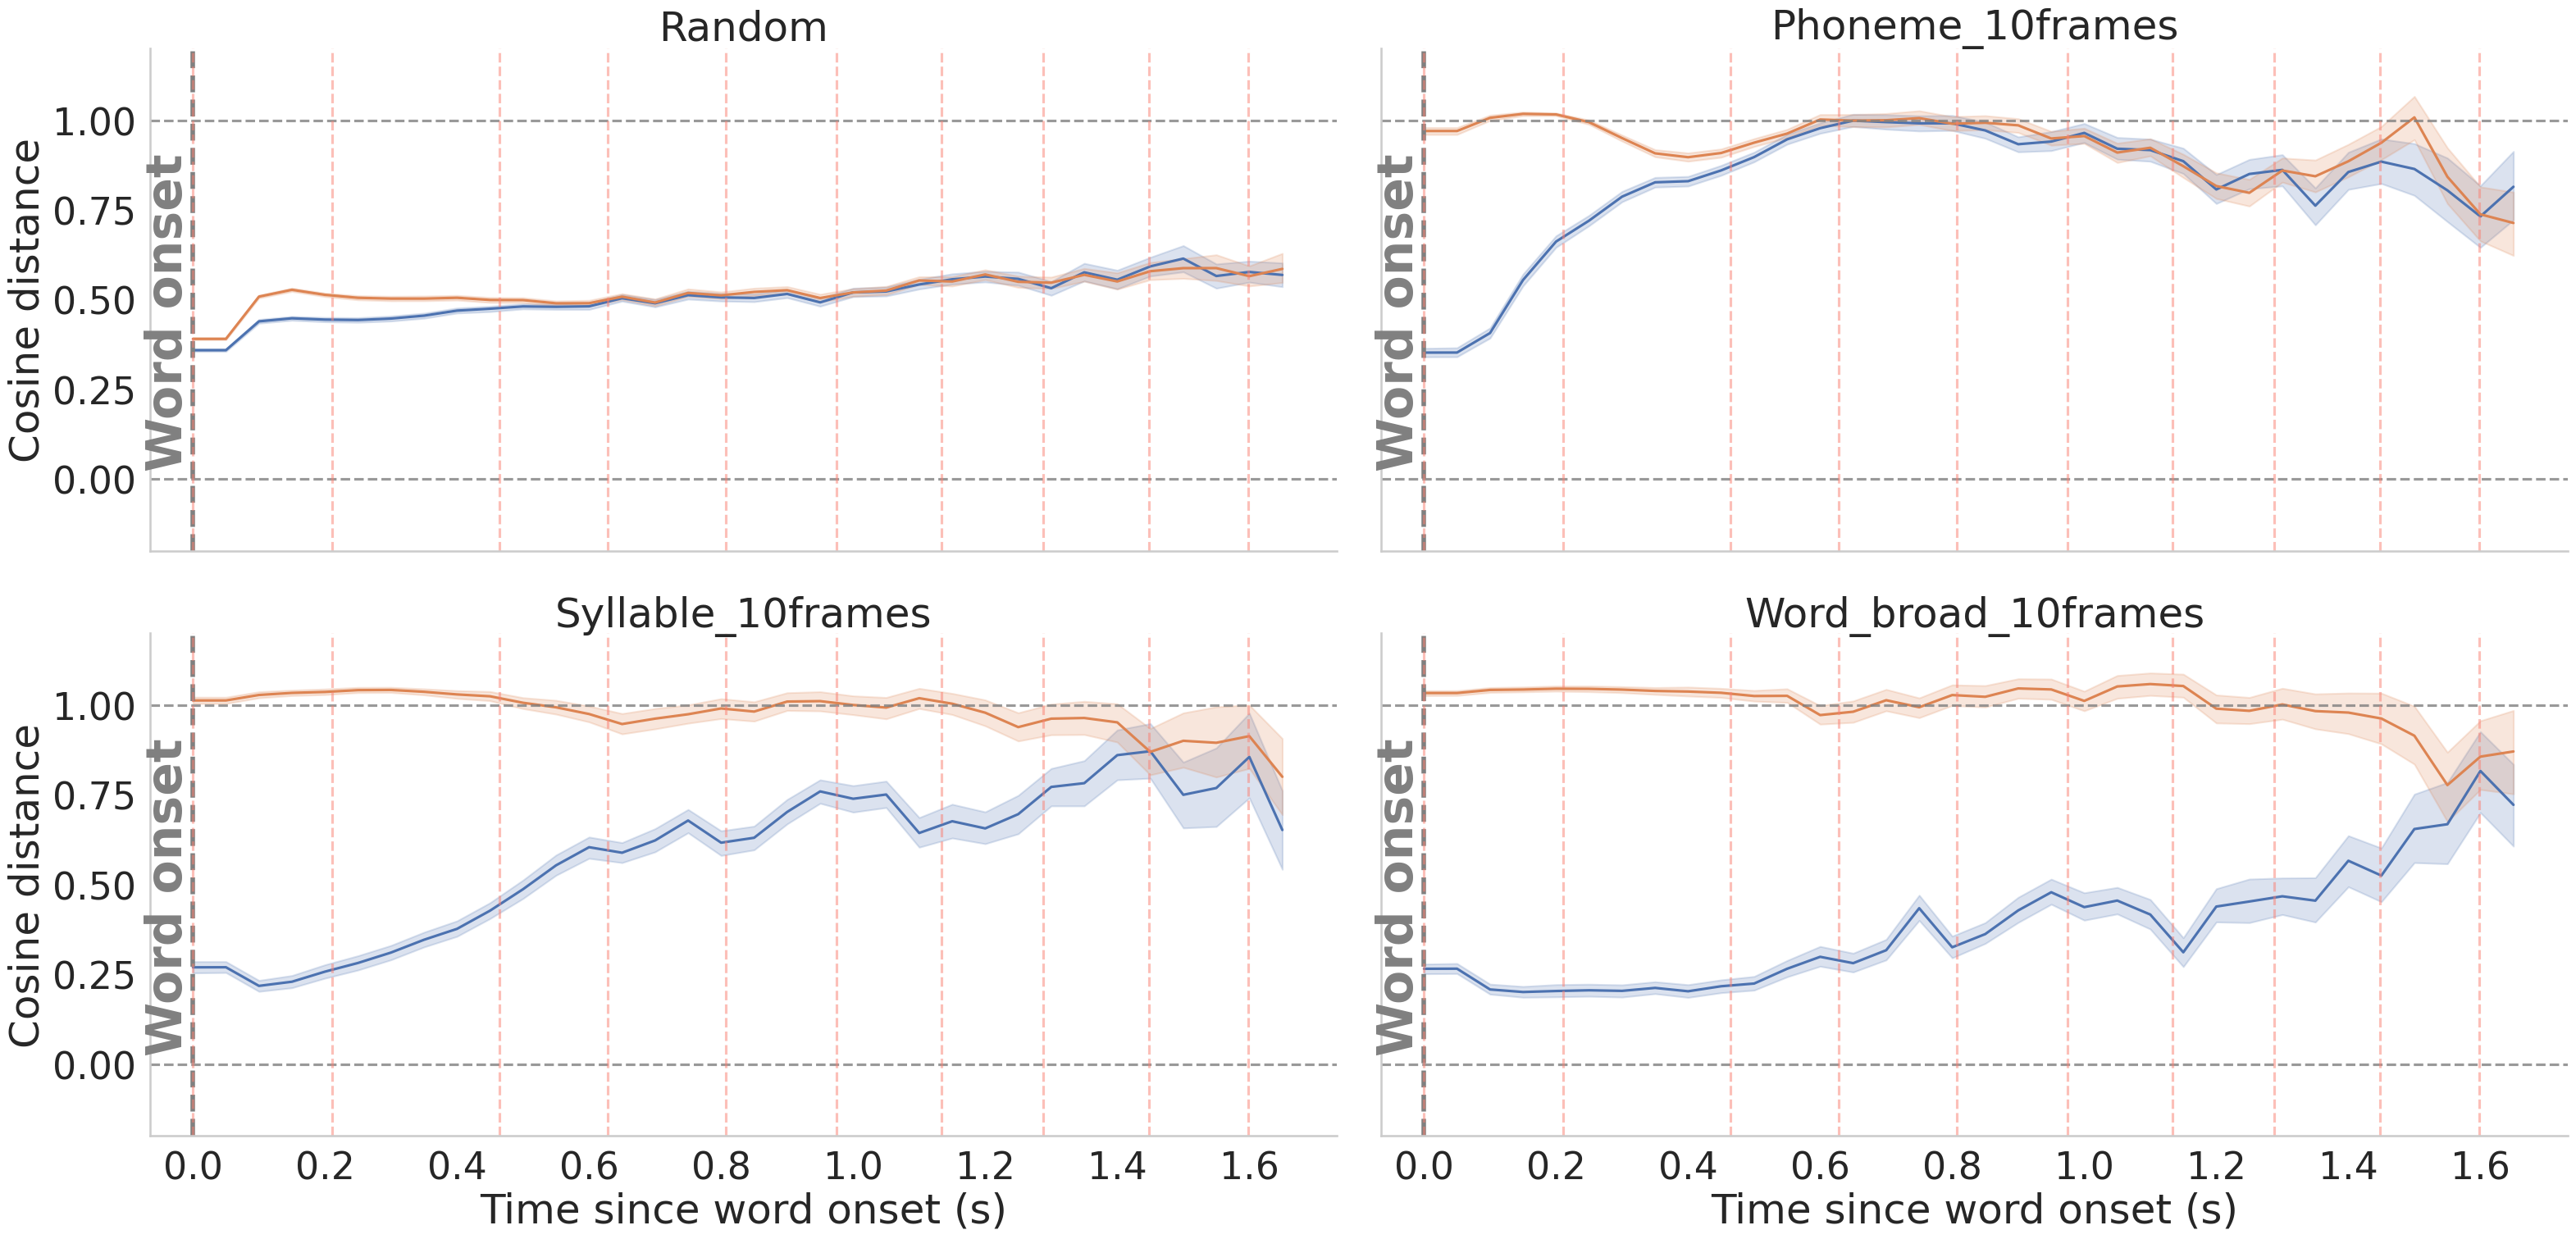

In [73]:
plot_coherence(word_onset_distance_df, "word", plot_phonemes=phoneme_in_word_mean_onsets)

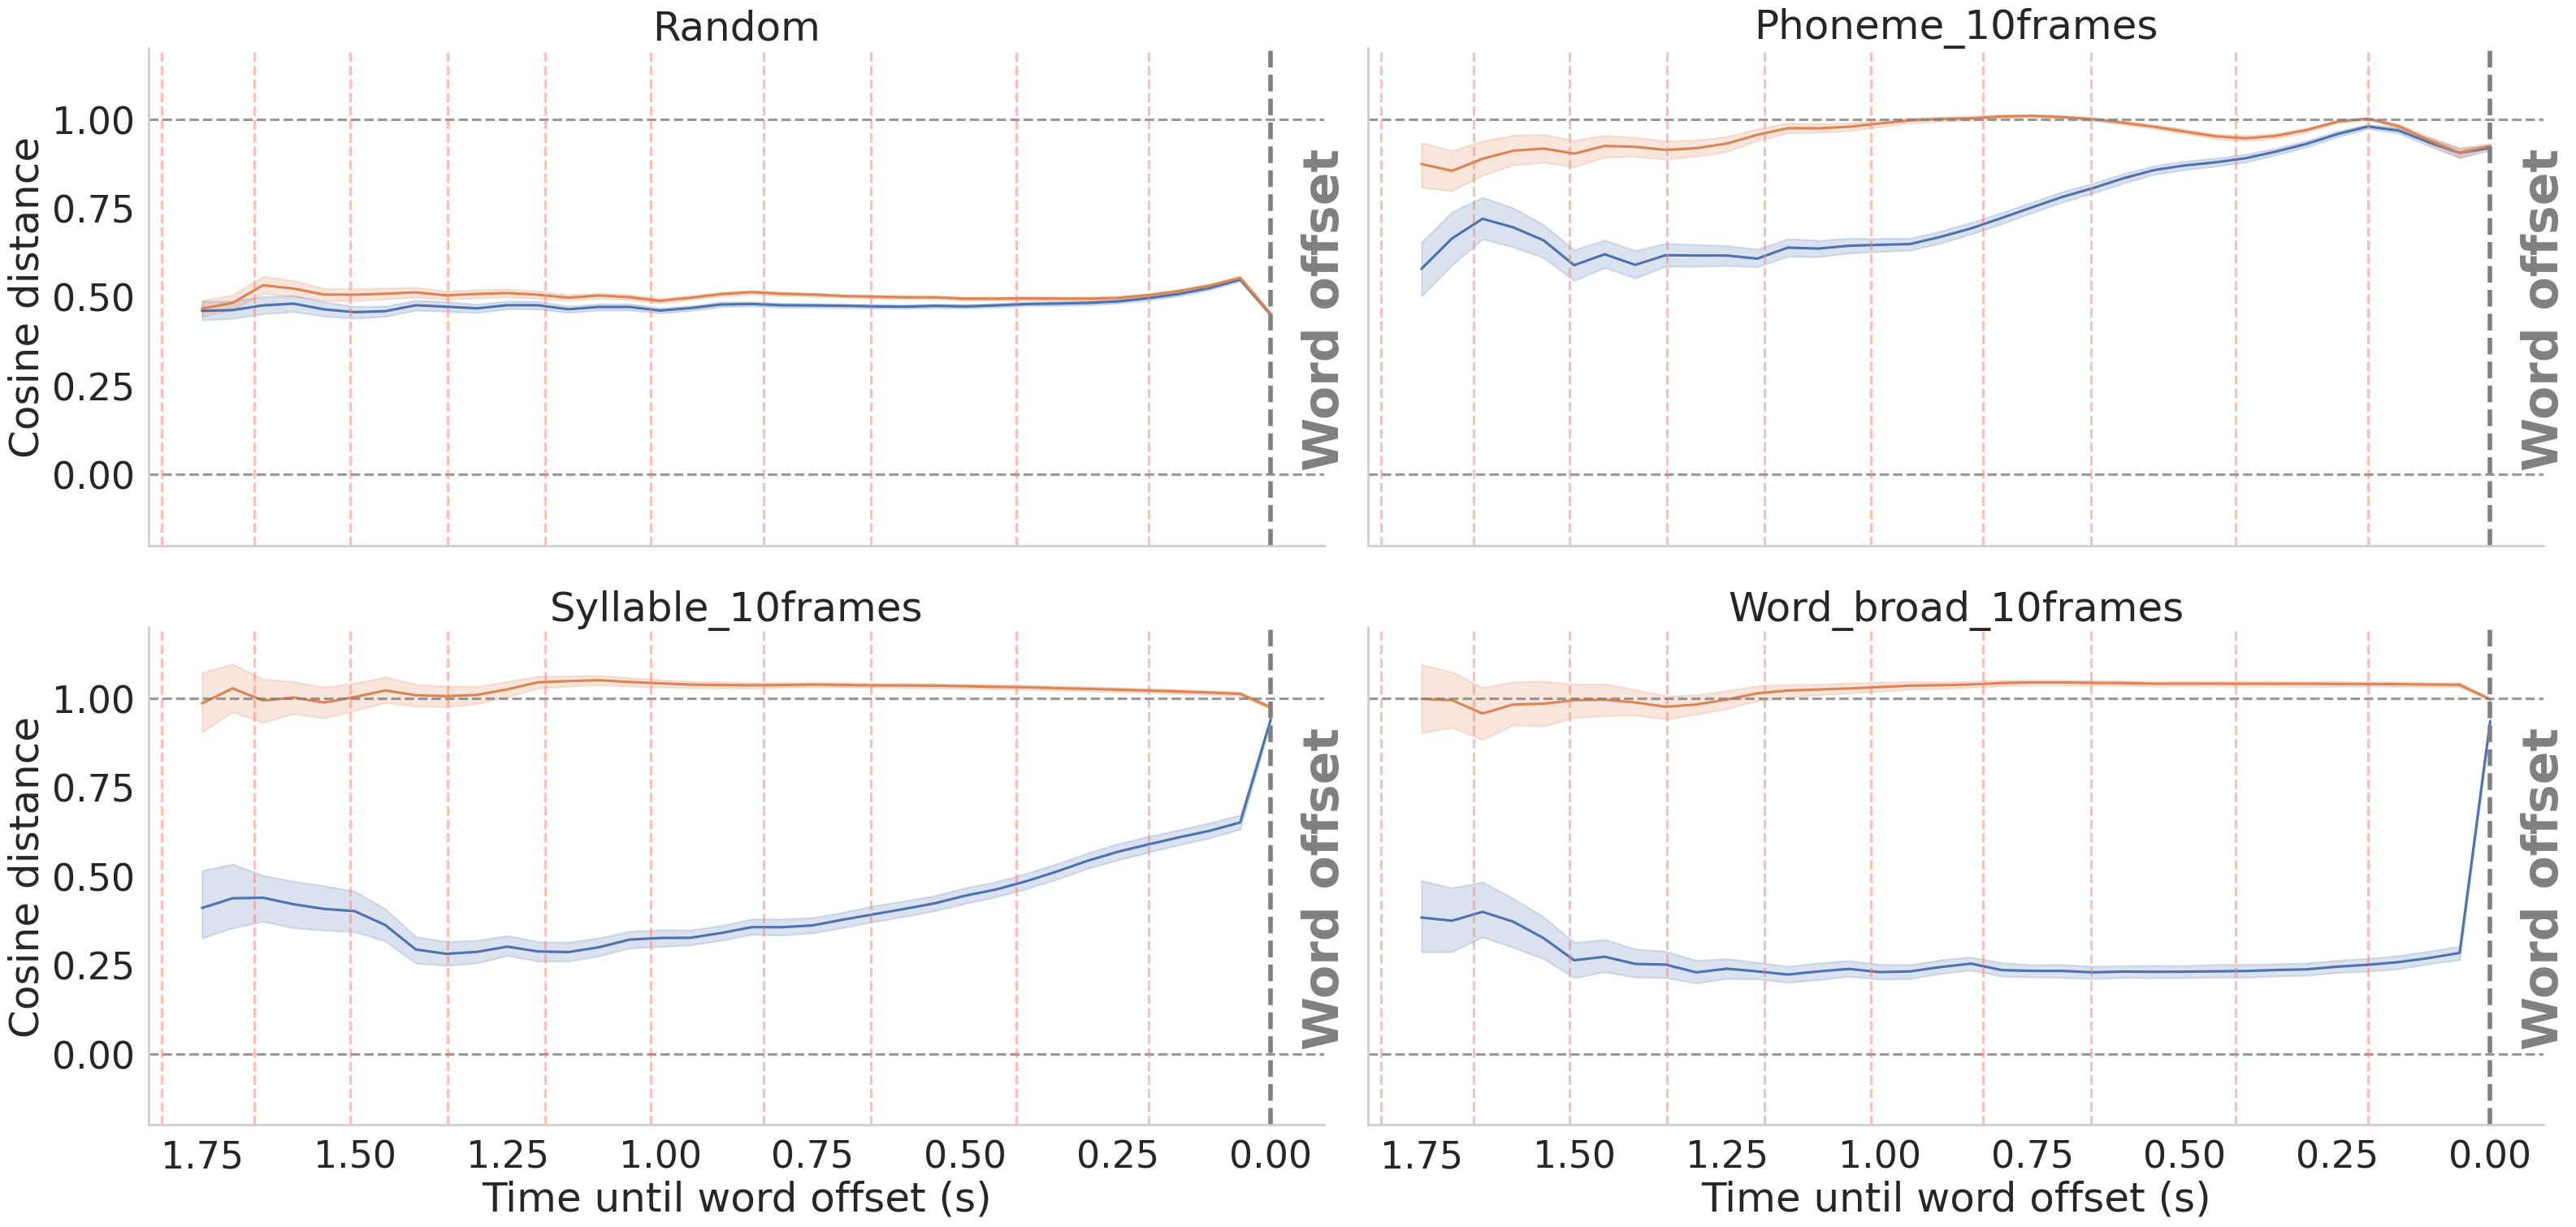

In [74]:
plot_coherence(word_onset_distance_align_offset_df, "word", alignment="offset", plot_phonemes=phoneme_in_word_reverse_mean_onsets)

### Grouped by offset

In [75]:
word_offset_distance_align_offset_df = load_grouped_distances("**/lexical_coherence/distances-grouped_offset_aligned_offset.csv", plot_model_classes, plot_equivalences)

In [76]:
# DEV
word_offset_distance_align_offset_df["time"] = (word_offset_distance_align_offset_df["frame"] - 1) / 20

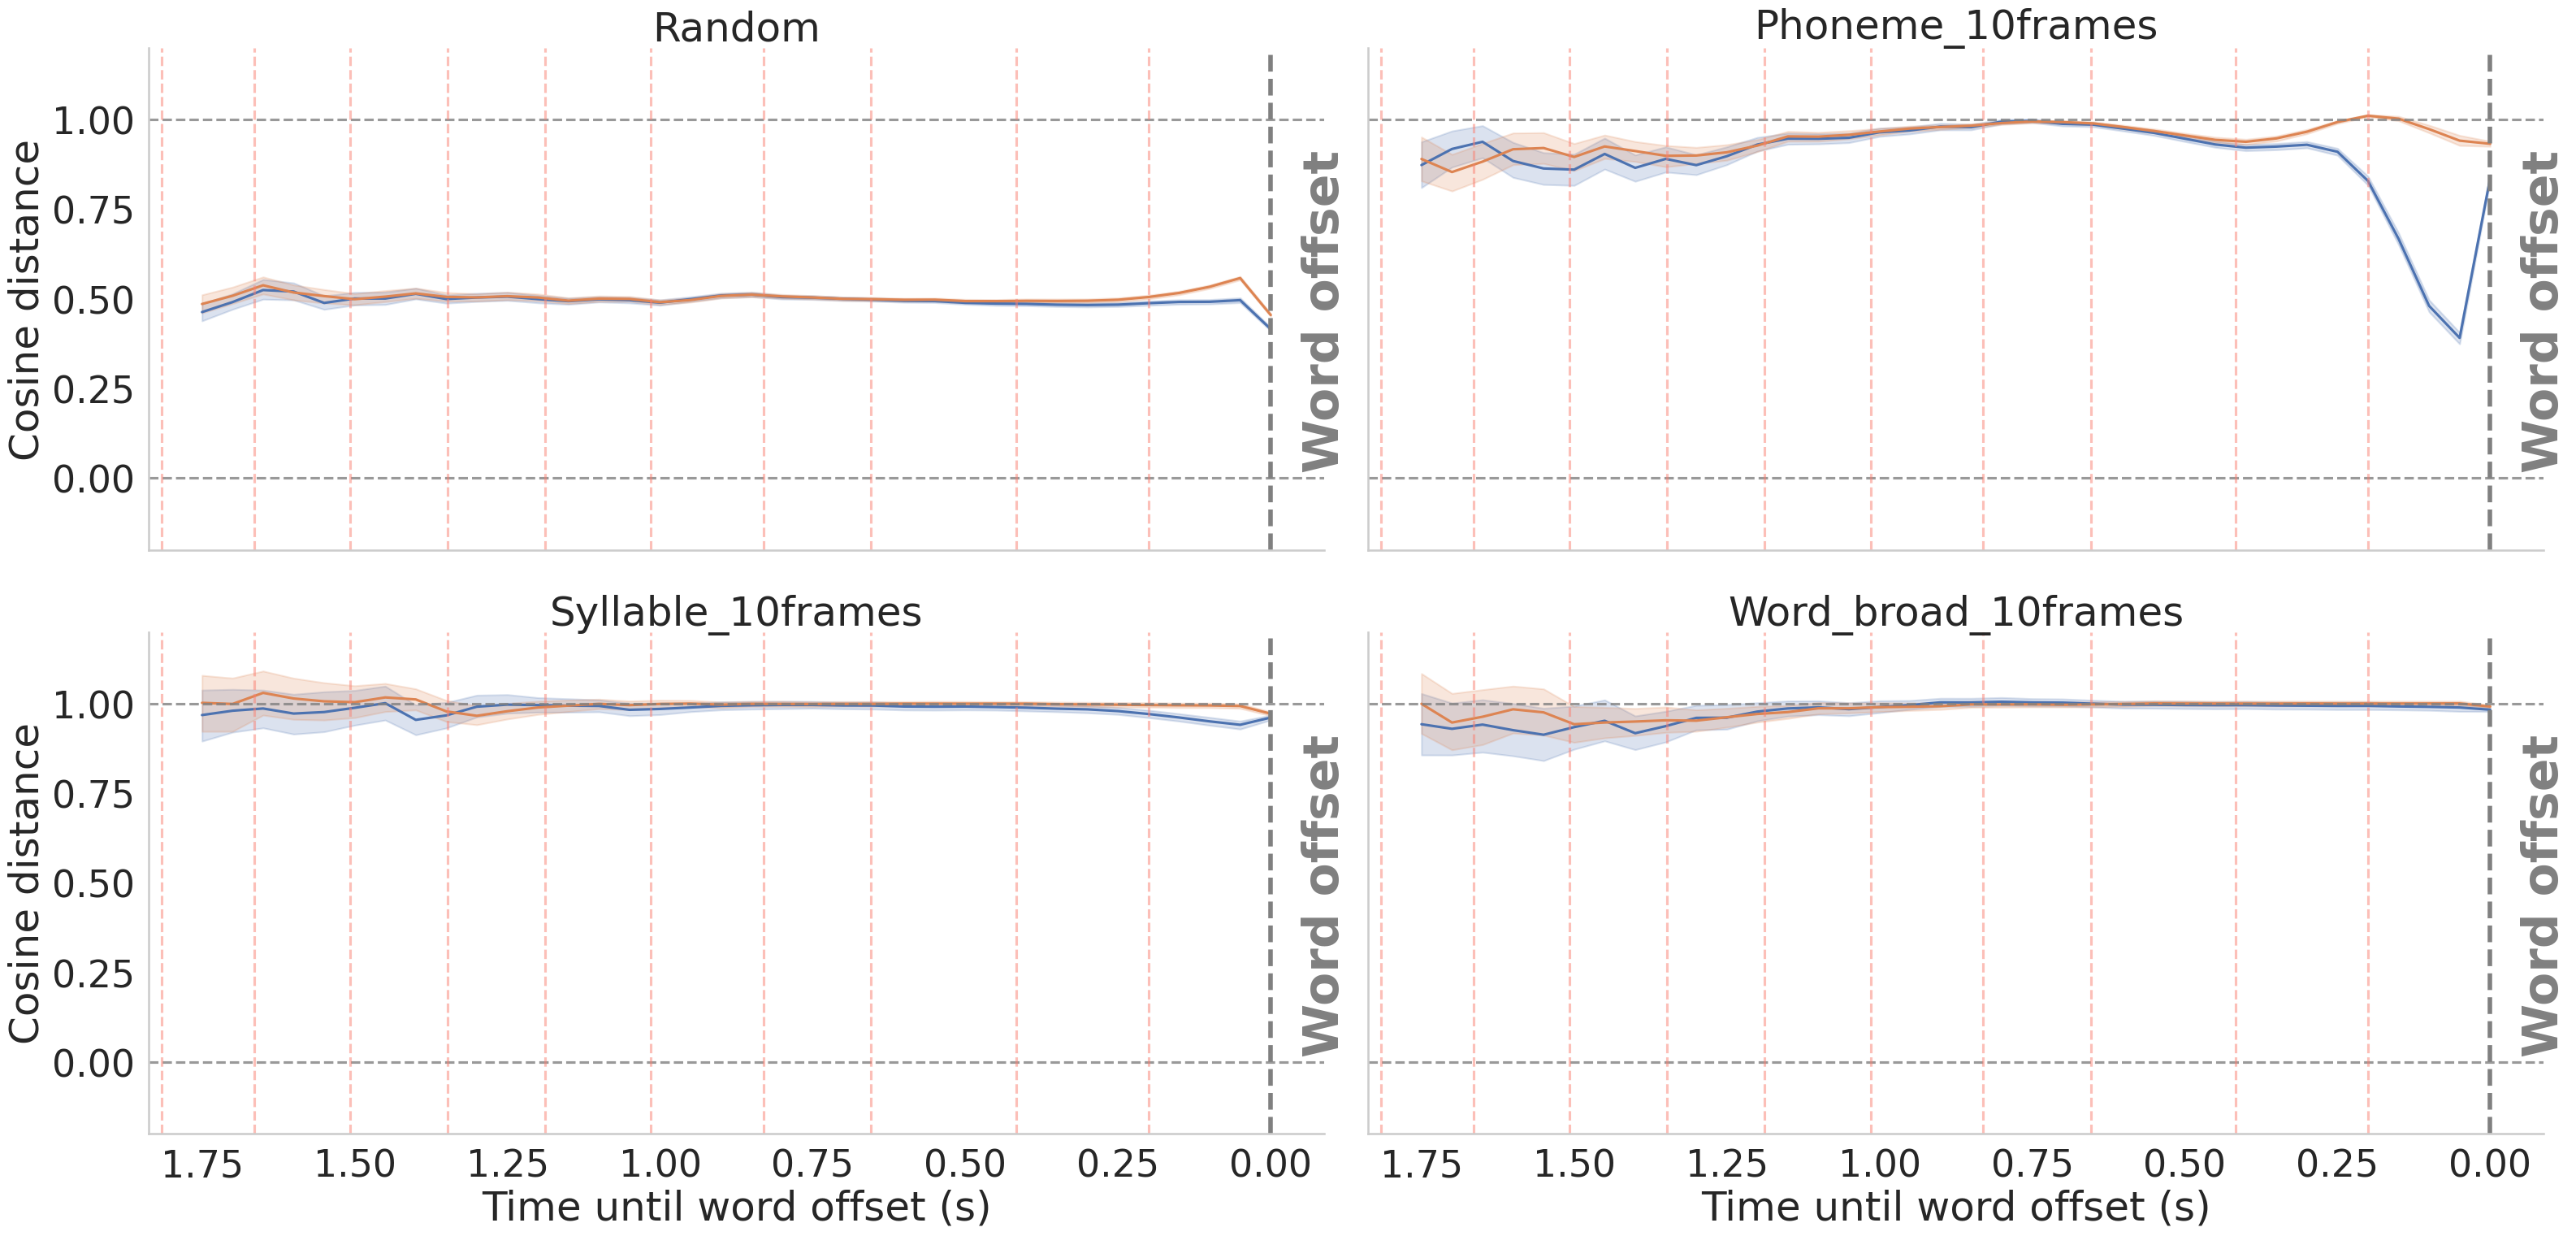

In [77]:
g = plot_coherence(word_offset_distance_align_offset_df, "word", alignment="offset",
                   plot_phonemes=phoneme_in_word_reverse_mean_onsets)

# adjust bottom of figure
g.fig.subplots_adjust(bottom=0.1)

# RSA analysis

## Phoneme level

In [80]:
phoneme_grouped_distances = pd.read_csv(f"outputs/notebooks/{plot_dataset}/{plot_base_model}/rnn_3-weightdecay0.01/phoneme_10frames/phoneme_coherence/grouped_distances.csv")

In [81]:
phoneme_rdm = phoneme_grouped_distances.pivot_table(index="p1", columns="p2", values="distance", aggfunc="mean")
phoneme_rdm.head()

p2  AA        AE        AH        AO        AW        AY         B        CH  \
p1                                                                             
AA NaN  0.066564  0.056450  0.048265  0.075348  0.057772  0.064896  0.332682   
AE NaN       NaN  0.060673  0.066163  0.066673  0.064041  0.069288  0.321639   
AH NaN       NaN       NaN  0.057842  0.059608  0.057948  0.051628  0.065170   
AO NaN       NaN       NaN       NaN  0.061215  0.045442  0.069603  0.337839   
AW NaN       NaN       NaN       NaN       NaN  0.073553  0.068352  0.343878   

p2         D        DH  ...        SH         T        TH        UH        UW  \
p1                      ...                                                     
AA  0.070008  0.066614  ...  0.294945  0.080114  0.246209  0.083886  0.119140   
AE  0.068625  0.066324  ...  0.390055  0.077625  0.246358  0.081352  0.092809   
AH  0.055432  0.046644  ...  0.064285  0.064008  0.064042  0.061935  0.066626   
AO  0.169739  0.071943  ...  0.296805  0.082675  0.249944  0.084134  0.118835   
AW  0.069610  0.067140  ...  0.390310  0.078802  0.247836  0.081017  0.104358   

p2         V         W         Y         Z        ZH  
p1                                                    
AA  0.147770  0.039301  0.048766  0.183592  0.215486  
AE  0.156802  0.047464  0.041226  0.181470  0.209929  
AH  0.054414  0.055401  0.055150  0.061033  0.065334  
AO  0.148718  0.035318  0.045277  0.187013  0.217795  
AW  0.153267  0.042710  0.044191  0.184021  0.213576  

[5 rows x 39 columns]

In [82]:
for p1 in phoneme_rdm.index:
    for p2 in phoneme_rdm.columns:
        if np.isnan(phoneme_rdm.loc[p1, p2]):
            phoneme_rdm.loc[p1, p2] = phoneme_rdm.loc[p2, p1]

# Set diagonal to 0
np.fill_diagonal(phoneme_rdm.values, 0)

<Axes: xlabel='p2', ylabel='p1'>

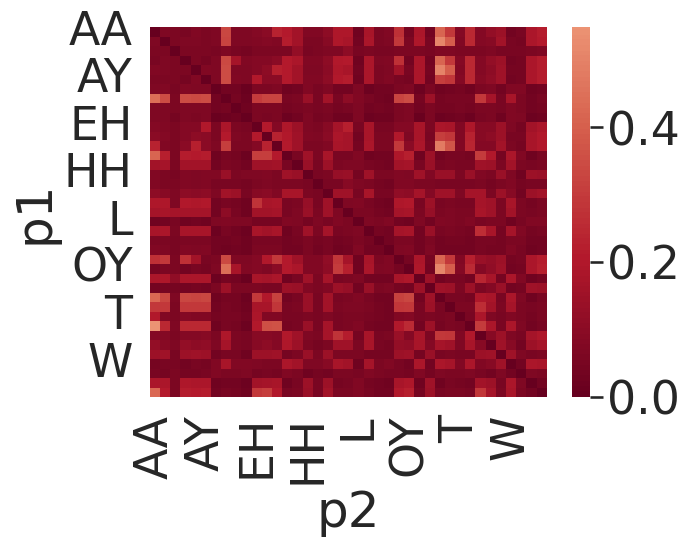

In [83]:
sns.heatmap(phoneme_rdm, center=1, cmap="RdBu")

Text(1454.4166666666665, 0.5, '')

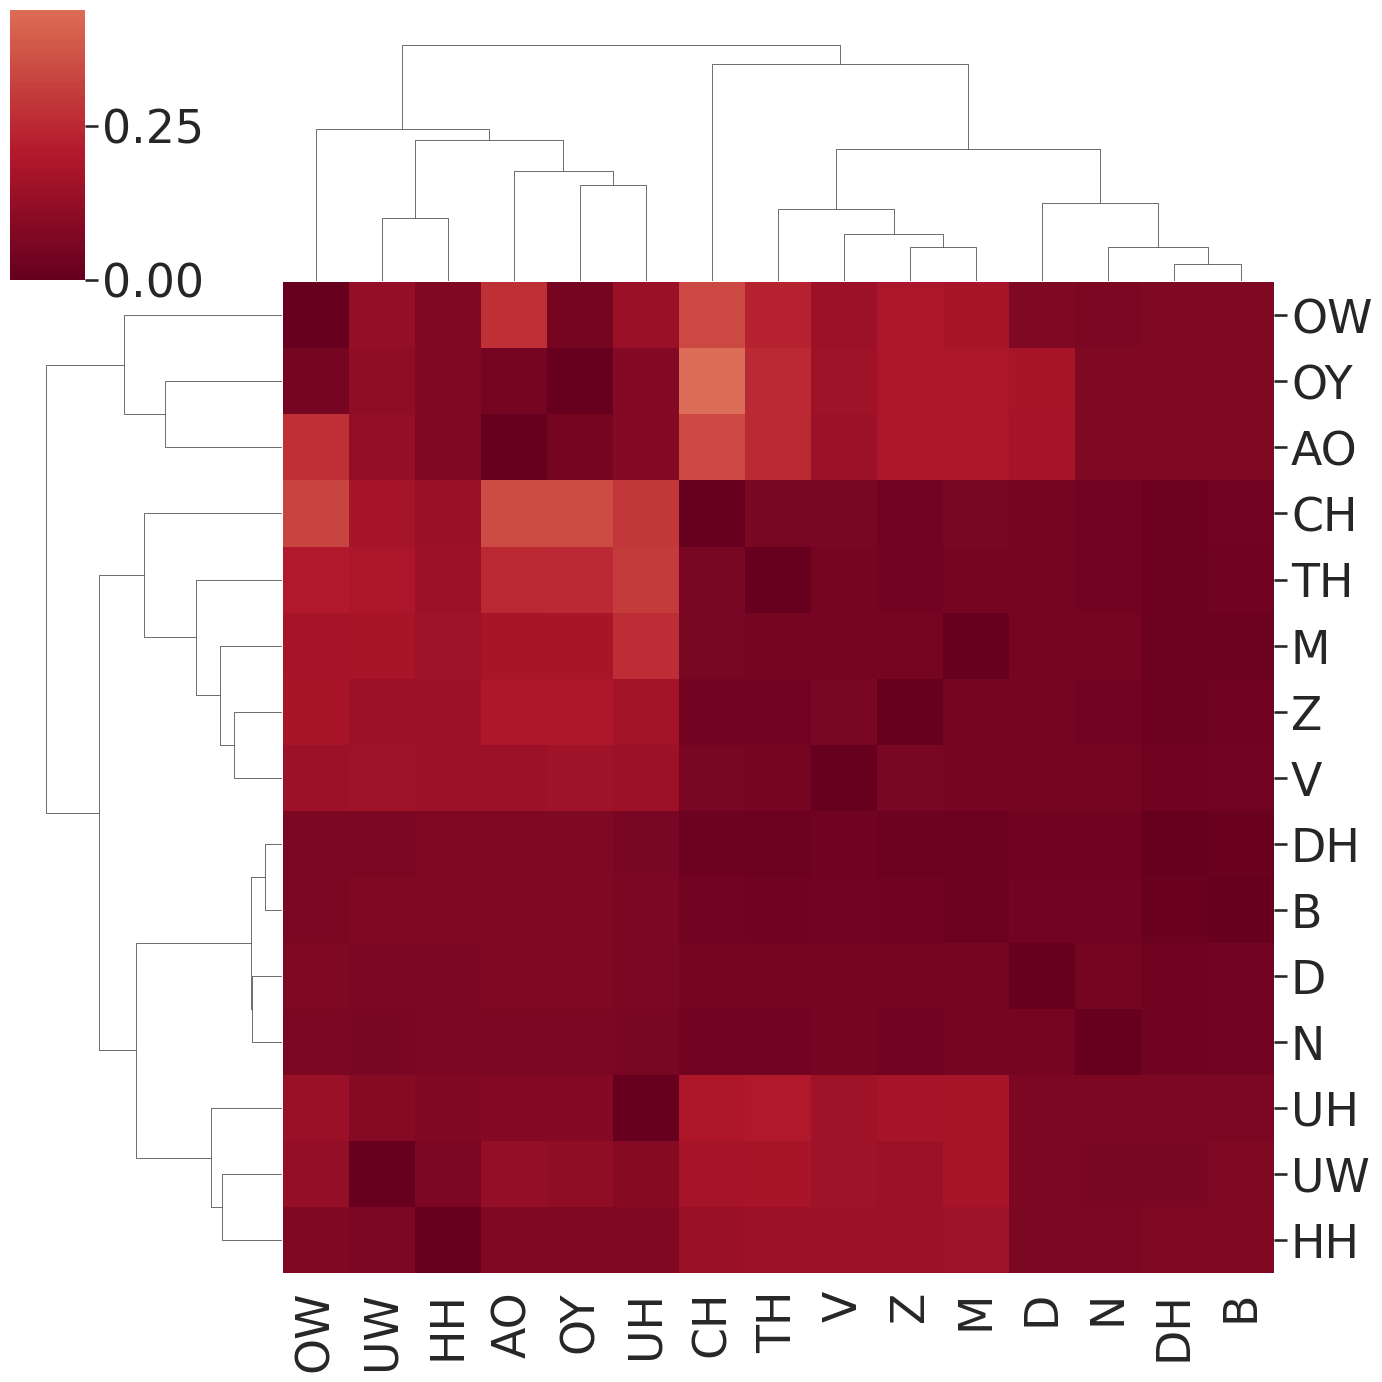

In [84]:
# f, ax = plt.subplots(figsize=(18, 18))
subsample_phonemes = np.random.choice(len(phoneme_rdm), 15, replace=False)
phoneme_rdm_subsample = phoneme_rdm.iloc[subsample_phonemes, subsample_phonemes]
g = sns.clustermap(phoneme_rdm_subsample, center=1, cmap="RdBu", figsize=(15, 15), colors_ratio=0.1)
g.ax_heatmap.set_xlabel(None)
g.ax_heatmap.set_ylabel(None)

Text(2804.4166666666665, 0.5, '')

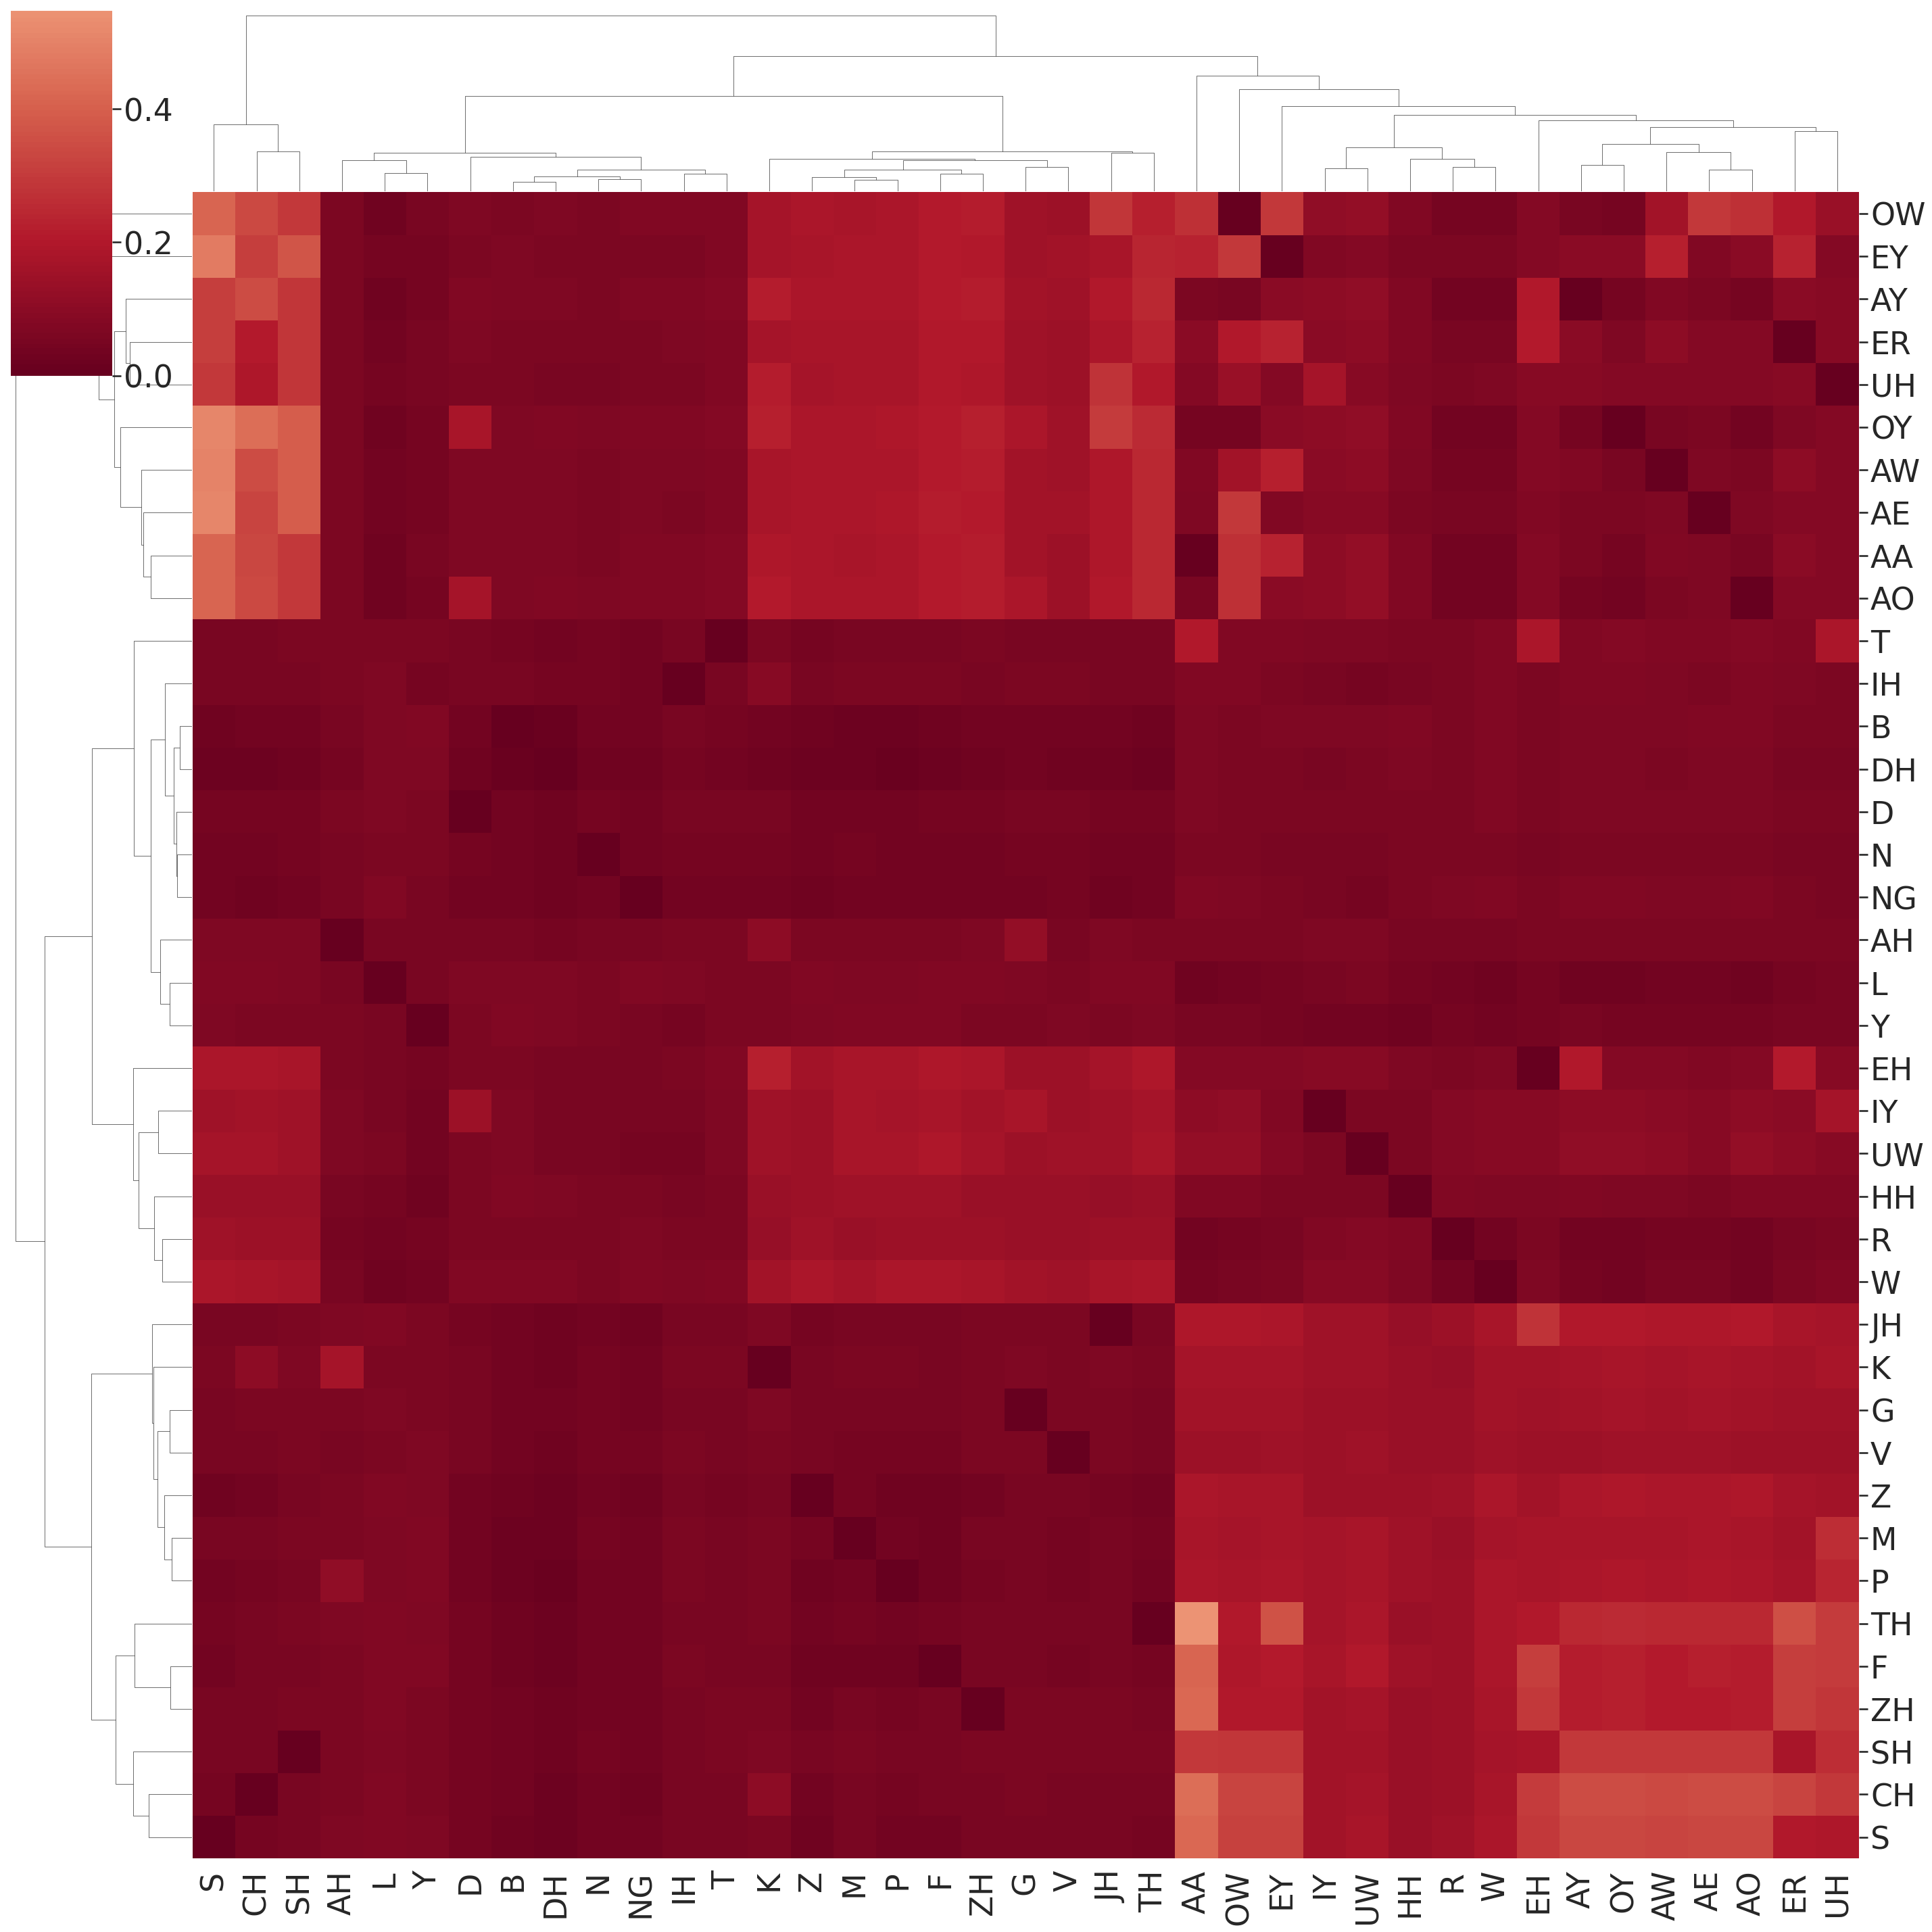

In [85]:
# f, ax = plt.subplots(figsize=(18, 18))
g = sns.clustermap(phoneme_rdm, center=1, cmap="RdBu", figsize=(30, 30), colors_ratio=0.1, dendrogram_ratio=0.1)
g.ax_heatmap.set_xlabel(None)
g.ax_heatmap.set_ylabel(None)